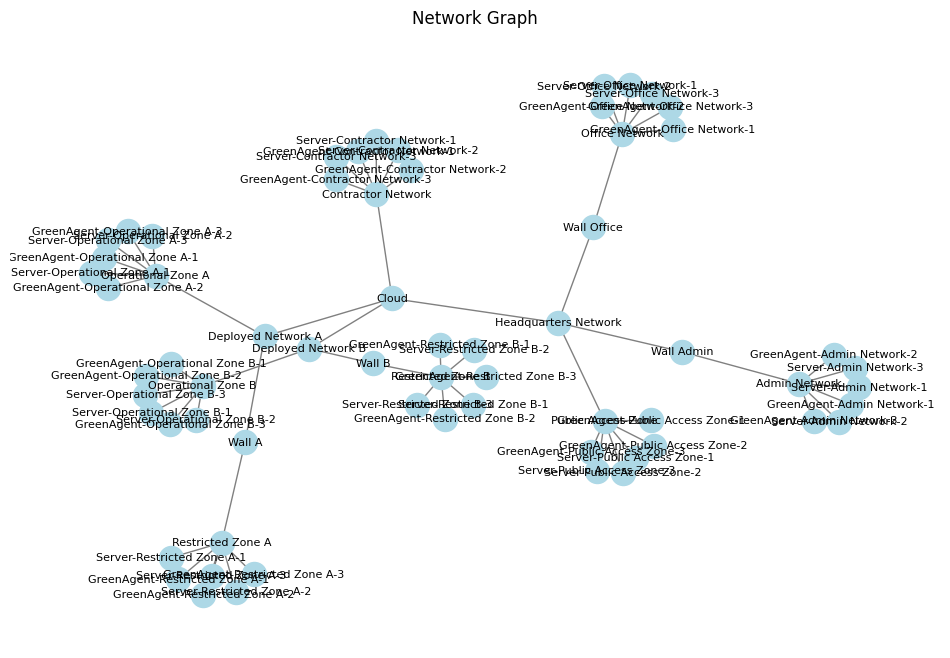

In [1]:
import random
import networkx as nx
import numpy as np

# Define the network partitions and system states
NETWORK_PARTITIONS = ["Contractor Network",
                      "Deployed Network A", "Operational Zone A", "Restricted Zone A",
                      "Deployed Network B", "Operational Zone B", "Restricted Zone B",
                      "Headquarters Network", "Public Access Zone", "Office Network", "Admin Network"]

STATE_UNKNOWN = 2
STATE_COMPROMISED = 1
STATE_SAFE = 0

# Define network status dictionary
network_status = {
    "Contractor Network": 1,
    "Deployed Network A": 1,
    "Deployed Network B": 1,
    "Headquarters Network": 1
}

# Define reward mapping for zones
ZONE_REWARDS = {
    "Headquarters Network": {
        "Local Work Fails": -1,
        "Access Service Fails": -1,  # Used for failed transfers
        "Red Impact/Access": -3,
        "Access Control": -1,
        "Server Compromise": -1  # Same as Local Work Fails
    },
    "Public Access Zone": {
        "Local Work Fails": -1,
        "Access Service Fails": -1,
        "Red Impact/Access": -3,
        "Access Control": -1,
        "Server Compromise": -1
    },
    "Office Network": {
        "Local Work Fails": -1,
        "Access Service Fails": -1,
        "Red Impact/Access": -3,
        "Access Control": -1,
        "Server Compromise": -1
    },
    "Admin Network": {
        "Local Work Fails": -1,
        "Access Service Fails": -1,
        "Red Impact/Access": -3,
        "Access Control": -1,
        "Server Compromise": -1
    },
    "Contractor Network": {
        "Local Work Fails": 0,
        "Access Service Fails": 0,
        "Red Impact/Access": 0,
        "Access Control": 0,
        "Server Compromise": 0
    },
    "Restricted Zone A": {
        "Local Work Fails": -1,
        "Access Service Fails": -3,  # Note the value is -3 here
        "Red Impact/Access": -1,
        "Access Control": -1,
        "Server Compromise": -1
    },
    "Operational Zone A": {
        "Local Work Fails": -1,
        "Access Service Fails": -1,
        "Red Impact/Access": -1,
        "Access Control": -1,
        "Server Compromise": -1
    },
    "Restricted Zone B": {
        "Local Work Fails": -1,
        "Access Service Fails": -3,  # Note the value is -3 here
        "Red Impact/Access": -1,
        "Access Control": -1,
        "Server Compromise": -1
    },
    "Operational Zone B": {
        "Local Work Fails": -1,
        "Access Service Fails": -1,
        "Red Impact/Access": -1,
        "Access Control": -1,
        "Server Compromise": -1
    }
}

class Agent:
    def __init__(self, agent_id, network_zone, team = ""):
        self.access_control = False
        self.agent_id = agent_id
        self.network_zone = network_zone
        self.compromised = False
        self.receive_buffer = []  # List for tracking incoming messages
        self.team = team #can be "Friend" or "Enemy"

    def get_id(self):
        return self.agent_id

class GreenAgent(Agent):
    def __init__(self, agent_id, network_zone, security_risk, team = ""):
        super().__init__(agent_id, network_zone, team)
        self.action_list = ["Local work", "Open email", "Transfer Information"]
        self.security_risk = security_risk  # Probability of compromise when opening email

    def open_email(self):
        is_malicious = random.random() < self.security_risk
        if is_malicious:
            self.compromised = True
            return f"{self.agent_id} opened a malicious email and was compromised."
        return f"{self.agent_id} opened an email safely."

    def perform_local_work(self):
        return f"{self.agent_id} is performing local work."

    def schedule_transfer(self, target_agent, distance):
        if distance == float('inf'):
            # Retrieve the "Access Service Fails" reward from ZONE_REWARDS based on the agent's network zone
            zone_reward = ZONE_REWARDS.get(self.network_zone, {})
            reward = zone_reward.get("Access Service Fails", 0)
            return f"{self.agent_id} failed to transfer information to {target_agent.agent_id} due to no path.", reward
        else:
            # Include the sender's compromised status at the time of sending
            message = {
                'sender': self.agent_id,
                'sender_compromised': self.compromised,
                'delay': distance
            }
            target_agent.receive_buffer.append(message)
            return f"{self.agent_id} scheduled information transfer to {target_agent.agent_id} after {distance} timesteps.", None

class RedAgent(Agent):
    def __init__(self, success_rate, team = ""):
        super().__init__("RedAgent", "Contractor Network", team)
        self.positions = []  # List of compromised green agents' positions
        self.action_list = ["Attack Server", "Transfer Information", "Sleep"]
        self.action_mapping = {i : action for i, action in enumerate(self.action_list)}
        self.success_rate = success_rate  # Probability of successful server attack

    def add_position(self, compromised_agent):
        if compromised_agent not in self.positions:
            self.positions.append(compromised_agent)

    def attack_server(self, servers):
        available_servers = [server for server in servers if not server.compromised]
        if available_servers and random.random() < self.success_rate:
            target_server = random.choice(available_servers)
            target_server.compromised = True
            return f"RedAgent successfully compromised {target_server.server_id}.", target_server
        return f"RedAgent failed to compromise a server.", None

    def schedule_transfer(self, sender_agent, target_agent, distance):
        if distance == float('inf'):
            # No negative reward for red agent's failed transfer
            return f"RedAgent failed to transfer information from {sender_agent.agent_id} to {target_agent.agent_id} due to no path.", None
        else:
            # Include the sender's compromised status (should be True)
            message = {
                'sender': sender_agent.agent_id,
                'sender_compromised': sender_agent.compromised,
                'delay': distance
            }
            target_agent.receive_buffer.append(message)
            return f"RedAgent scheduled information transfer from {sender_agent.agent_id} to {target_agent.agent_id} after {distance} timesteps.", None

class BlueAgent(Agent):
    def __init__(self, agent_id, network_zone, subnet_type, team = ""):
        super().__init__(agent_id, network_zone, team)
        self.reboot_limit = 2
        self.subnet_type = subnet_type
        self.action_mapping = self._create_action_mapping()
        self.decoy_targets = {}
        self.observation_order = self._get_observation_order()

    def _get_observation_order(self):
        if self.subnet_type == "Headquarters":
            # Observation order for HQ defender
            observation_order = []
            zones = ["Public Access Zone", "Office Network", "Admin Network"]
            for zone in zones:
                for i in range(3):
                    observation_order.append(f"GreenAgent-{zone}-{i+1}")
                for i in range(3):
                    observation_order.append(f"Server-{zone}-{i+1}")
            return observation_order
        else:
            # Observation order for deployed networks
            observation_order = []
            for i in range(3):
                observation_order.append(f"GreenAgent-{self.network_zone}-{i+1}")
            for i in range(3):
                observation_order.append(f"Server-{self.network_zone}-{i+1}")
            return observation_order

    def _create_action_mapping(self):
        actions = self.action_space()
        action_mapping = {i: action for i, action in enumerate(actions)}
        return action_mapping

    def monitor(self):
        return f"{self.agent_id} is monitoring the {self.network_zone}."

    def reboot(self, target):
        target_id = target.get_id()
        if target.compromised:
            target.compromised = False  # Change state to safe
            return f"{self.agent_id} rebooted {target_id}."
        else:
            return f"{target_id} was not compromised."


    def deploy_decoy(self, target):
        # Deploy decoy on target agent for 1 step
        self.decoy_targets[target.agent_id] = 1  # Decoy lasts for 1 step
        return f"{self.agent_id} deployed decoy on {target.agent_id}."

    def update_decoys(self):
        # Decrease decoy timers and remove expired decoys
        expired_decoys = [agent_id for agent_id, steps in self.decoy_targets.items() if steps <= 0]
        for agent_id in expired_decoys:
            del self.decoy_targets[agent_id]
        # Decrease the decoy steps for active decoys
        for agent_id in self.decoy_targets:
            self.decoy_targets[agent_id] -= 1

    def action_space(self):
        actions = []

        if self.subnet_type == "Headquarters":
            # Specific green agents and servers in each HQ subnetwork
            zones = ["Public Access Zone", "Office Network", "Admin Network"]
            green_agents_by_zone = {zone: [f"GreenAgent-{zone}-{i+1}" for i in range(3)] for zone in zones}
            servers_by_zone = {zone: [f"Server-{zone}-{i+1}" for i in range(3)] for zone in zones}

            # Flatten lists of agents and servers
            all_green_agents = [agent for agents in green_agents_by_zone.values() for agent in agents]
            all_servers = [server for servers in servers_by_zone.values() for server in servers]

            # Reboot single agents
            for ga in all_green_agents:
                actions.append(f"Reboot {ga}")

            # Reboot single servers
            for server in all_servers:
                actions.append(f"Reboot {server}")

            # Reboot two agents (from the same zone)
            for zone in zones:
                green_agents = green_agents_by_zone[zone]
                for i, ga1 in enumerate(green_agents):
                    for ga2 in green_agents[i+1:]:
                        actions.append(f"Reboot {ga1} and {ga2}")

            # Reboot two servers (from the same zone)
            for zone in zones:
                servers = servers_by_zone[zone]
                for i, server1 in enumerate(servers):
                    for server2 in servers[i+1:]:
                        actions.append(f"Reboot {server1} and {server2}")

            # Reboot one agent and one server (from the same zone)
            for zone in zones:
                green_agents = green_agents_by_zone[zone]
                servers = servers_by_zone[zone]
                for ga in green_agents:
                    for server in servers:
                        actions.append(f"Reboot {ga} and {server}")

            # Monitoring action
            actions.append(f"Monitor {self.network_zone}")

            # Enable/Disable Access Control actions
            for ga in all_green_agents:
                actions.append(f"Enable Access Control on {ga}")
                actions.append(f"Disable Access Control on {ga}")

            # Add Decoy actions
            for target in all_green_agents:
                actions.append(f"Deploy Decoy on {target}")

        else:
            # For Deployed Networks
            green_agents = [f"GreenAgent-{self.network_zone}-{i+1}" for i in range(3)]
            servers = [f"Server-{self.network_zone}-{i+1}" for i in range(3)]

            # Reboot single agents
            for ga in green_agents:
                actions.append(f"Reboot {ga}")

            # Reboot single servers
            for server in servers:
                actions.append(f"Reboot {server}")

            # Reboot two agents
            for i, ga1 in enumerate(green_agents):
                for ga2 in green_agents[i+1:]:
                    actions.append(f"Reboot {ga1} and {ga2}")

            # Reboot two servers
            for i, server1 in enumerate(servers):
                for server2 in servers[i+1:]:
                    actions.append(f"Reboot {server1} and {server2}")

            # Reboot one agent and one server
            for ga in green_agents:
                for server in servers:
                    actions.append(f"Reboot {ga} and {server}")

            # Monitoring action
            actions.append(f"Monitor {self.network_zone}")

            # Enable/Disable Access Control actions
            for ga in green_agents:
                actions.append(f"Enable Access Control on {ga}")
                actions.append(f"Disable Access Control on {ga}")

            # Add Decoy actions
            for target in green_agents:
                actions.append(f"Deploy Decoy on {target}")

        return actions

class Server:
    def __init__(self, server_id, network_zone):
        self.server_id = server_id
        self.network_zone = network_zone
        self.compromised = False

    def get_id(self):
        return self.server_id

class CAGE4Environment:
    def __init__(self, security_risk=0.4, success_rate=0.4, debug=False, team = ""):
        self.debug = debug
        self.graph = nx.Graph()
        self.green_agents = {}
        if team == "Friend":
            self.red_agent = RedAgent(success_rate, "Enemy")
        elif team == "Enemy":
            self.red_agent = RedAgent(success_rate, "Friend")
        else:
            self.red_agent = RedAgent(success_rate)
        self.blue_agents = {}
        self.servers = {}
        self.step_count = 0
        self.step_threshold = 100
        self.security_risk = security_risk
        self.true_state = {}
        self.team = team #can be either Friend or Enemy

    def _debug_print(self, message):
        if self.debug:
            print(message)

    def reset(self):
        # Clear all data structures
        self.graph.clear()
        self.green_agents.clear()
        self.servers.clear()
        self.blue_agents.clear()
        self.true_state.clear()
        self.red_agent.positions.clear()
    
        # Setup the environment anew
        self.setup_environment()
        self._initialize_true_state()
    
        # Reset network status
        for partition in network_status:
            network_status[partition] = 1
    
        self.step_count = 0  # Reset step count
    
        # Add blue agents
        self.blue_agents["BlueAgent-OperationalZoneA"] = BlueAgent("BlueAgent-OperationalZoneA", "Operational Zone A", "Deployed", team = self.team)
        self.blue_agents["BlueAgent-RestrictedZoneA"] = BlueAgent("BlueAgent-RestrictedZoneA", "Restricted Zone A", "Deployed", team = self.team)
        self.blue_agents["BlueAgent-OperationalZoneB"] = BlueAgent("BlueAgent-OperationalZoneB", "Operational Zone B", "Deployed", team = self.team)
        self.blue_agents["BlueAgent-RestrictedZoneB"] = BlueAgent("BlueAgent-RestrictedZoneB", "Restricted Zone B", "Deployed", team = self.team)
        self.blue_agents["BlueAgent-HQ"] = BlueAgent("BlueAgent-HQ", "Headquarters Network", "Headquarters", team = self.team)
    
        observations = {}
        info = {}
        for blue_agent_id, blue_agent in self.blue_agents.items():
            observation = []
            for entity_id in blue_agent.observation_order:
                observation.append(self.true_state.get(entity_id, STATE_UNKNOWN))
            observations[blue_agent_id] = observation
    
        return observations, info


    def setup_environment(self):
        # Adding the cloud node as the root
        self.graph.add_node("Cloud")

        # Setting up the main network nodes and edges to the cloud
        for partition in ["Contractor Network", "Deployed Network A", "Deployed Network B", "Headquarters Network"]:
            self.graph.add_node(partition)
            self.graph.add_edge("Cloud", partition)

        # Setting up subnetwork zones for each deployed network and headquarters with walls as separate nodes
        self._add_wall("Deployed Network A", "Restricted Zone A", "Wall A")
        self._setup_zones("Deployed Network A", ["Operational Zone A"])

        self._add_wall("Deployed Network B", "Restricted Zone B", "Wall B")
        self._setup_zones("Deployed Network B", ["Operational Zone B"])

        self._add_wall("Headquarters Network", "Office Network", "Wall Office")
        self._add_wall("Headquarters Network", "Admin Network", "Wall Admin")

        self._setup_zones("Headquarters Network", ["Public Access Zone"])

        # Adding agents and servers as nodes under each zone
        for zone in ["Contractor Network", "Operational Zone A", "Restricted Zone A", "Operational Zone B",
                     "Restricted Zone B", "Public Access Zone", "Office Network", "Admin Network"]:
            self._add_agents_and_servers(zone)

        # Set the first green agent in Contractor Network as compromised
        contractor_agents = [agent for agent in self.green_agents.values() if agent.network_zone == "Contractor Network"]
        if contractor_agents:
            compromised_agent = contractor_agents[0]
            compromised_agent.compromised = True
            self.red_agent.add_position(compromised_agent)


    def _setup_zones(self, parent, zones):
        for zone in zones:
            self.graph.add_node(zone)
            self.graph.add_edge(parent, zone)

    def _add_wall(self, network, zone, wall_name):
        self.graph.add_node(wall_name)
        self.graph.add_node(zone)
        self.graph.add_edge(network, wall_name)
        self.graph.add_edge(zone, wall_name)

    def _add_agents_and_servers(self, zone):
        for i in range(3):
            green_agent = GreenAgent(f"GreenAgent-{zone}-{i+1}", zone, self.security_risk, team = self.team)
            self.green_agents[green_agent.agent_id] = green_agent
            self.graph.add_node(green_agent.agent_id)
            self.graph.add_edge(green_agent.agent_id, zone)

            server = Server(f"Server-{zone}-{i+1}", zone)
            self.servers[server.server_id] = server
            self.graph.add_node(server.server_id)
            self.graph.add_edge(server.server_id, zone)

    def _initialize_true_state(self):
        for agent_id in self.green_agents:
            self.true_state[agent_id] = STATE_SAFE
        for server_id in self.servers:
            self.true_state[server_id] = STATE_SAFE

        # Update the state of compromised agents
        for agent in self.green_agents.values():
            if agent.compromised:
                self.true_state[agent.agent_id] = STATE_COMPROMISED

    def step(self, blue_agent_actions, red_agent_actions = None):
        observations = {}
        rewards = {}
        term = {}
        trunc = {}
        info = {}
        accumulated_reward = 0  # Total reward accumulated in this step
        red_accumulated_reward = 0


        self.update_true_state()

        self.step_count += 1

        # Update edges for nodes with access control enabled
        for green_agent in list(self.green_agents.values()):
            if green_agent.access_control:
                if self.graph.has_edge(green_agent.agent_id, green_agent.network_zone):
                    self.graph.remove_edge(green_agent.agent_id, green_agent.network_zone)
            else:
                if not self.graph.has_edge(green_agent.agent_id, green_agent.network_zone):
                    self.graph.add_edge(green_agent.agent_id, green_agent.network_zone)

        # Update edges based on network status
        for partition, status in network_status.items():
            if status == 0 and self.graph.has_edge("Cloud", partition):
                self.graph.remove_edge("Cloud", partition)
            elif status == 1 and not self.graph.has_edge("Cloud", partition):
                self.graph.add_edge("Cloud", partition)

        # Step 1: Green Agents take action
        for green_agent in self.green_agents.values():
            # Initialize agent's reward
            agent_reward = 0

            if green_agent.compromised:
                # Agent's actions fail due to being compromised
                zone_reward = ZONE_REWARDS.get(green_agent.network_zone, {})
                reward = zone_reward.get("Local Work Fails", 0)
                agent_reward += reward
                accumulated_reward += reward
                self._debug_print(f"{green_agent.agent_id} failed to perform actions due to being compromised.")
                continue  # Agent cannot perform any action

            if green_agent.access_control:
                # Agent cannot perform actions due to access control
                zone_reward = ZONE_REWARDS.get(green_agent.network_zone, {})
                ac_reward = zone_reward.get("Access Control", 0)
                agent_reward += ac_reward
                accumulated_reward += ac_reward
                self._debug_print(f"{green_agent.agent_id} failed to perform actions due to access control.")
                continue  # Agent cannot perform any action

            action = random.choice(green_agent.action_list)

            if action == "Open email":
                result = green_agent.open_email()
                if green_agent.compromised:
                    self.red_agent.add_position(green_agent)  # Add compromised green agent to red agent's positions
                    # No immediate reward change for compromise here
                self._debug_print(result)
            elif action == "Transfer Information":
                target_agent = random.choice(list(self.green_agents.values()))
                distance = self.calculate_distance(green_agent.agent_id, target_agent.agent_id)
                result, reward = green_agent.schedule_transfer(target_agent, distance)
                if reward is not None:
                    agent_reward += reward
                    accumulated_reward += reward
                self._debug_print(result)
            else:
                # Local work succeeds
                self._debug_print(f"{green_agent.agent_id} is performing local work.")
                # No reward change for successful local work

        # Step 2: Process receive buffers for all agents
        for agent in self.green_agents.values():
            if agent.access_control:
                self._debug_print(f"{agent.agent_id} cannot receive messages due to access control.")
                continue  # Skip processing receive buffer

            new_buffer = []
            for message in agent.receive_buffer:
                message['delay'] -= 1
                if message['delay'] == 0:
                    sender_id = message['sender']
                    sender_compromised = message['sender_compromised']  # Use stored sender status
                    # Check if path exists between sender and receiver at time of delivery
                    if self.calculate_distance(sender_id, agent.agent_id) != float('inf'):
                        # Path exists
                        if agent.compromised:
                            # Receiver is compromised at time of delivery
                            if sender_id.startswith("GreenAgent"):
                                # Apply Access Service Fails penalty for sender's subnet
                                sender_agent = self.green_agents.get(sender_id)
                                if sender_agent:
                                    zone_reward = ZONE_REWARDS.get(sender_agent.network_zone, {})
                                    reward = zone_reward.get("Access Service Fails", 0)
                                    accumulated_reward += reward
                            self._debug_print(f"{agent.agent_id} is compromised and cannot receive the message from {sender_id}.")
                            continue
                        if sender_compromised:
                            # Check for decoy
                            decoy_active = any(agent.agent_id in blue_agent.decoy_targets for blue_agent in self.blue_agents.values())
                            if decoy_active:
                                # Attack is prevented and reversed
                                self._debug_print(f"Attack on {agent.agent_id} was prevented by decoy.")
                                # No compromise occurs
                            else:
                                # Compromised sender compromises the receiver
                                agent.compromised = True
                                self.red_agent.add_position(agent)
                                self._debug_print(f"{agent.agent_id} was compromised by {sender_id}.")

                                # Apply red impact reward
                                zone_reward = ZONE_REWARDS.get(agent.network_zone, {})
                                reward = zone_reward.get("Red Impact/Access", 0)
                                accumulated_reward += reward
                        else:
                            # Successful information transfer
                            self._debug_print(f"{agent.agent_id} successfully received information from {sender_id}.")
                    else:
                        # No path exists at time of delivery
                        if sender_id.startswith("GreenAgent"):
                            # Apply Access Service Fails reward for sender's subnet
                            sender_agent = self.green_agents.get(sender_id)
                            if sender_agent:
                                zone_reward = ZONE_REWARDS.get(sender_agent.network_zone, {})
                                reward = zone_reward.get("Access Service Fails", 0)
                                accumulated_reward += reward
                                self._debug_print(f"{agent.agent_id} failed to receive information from {sender_id} due to no path.")
                        else:
                            # No negative reward for failed transfers from red agents
                            self._debug_print(f"{agent.agent_id} failed to receive information from {sender_id} due to no path.")
                else:
                    new_buffer.append(message)
            agent.receive_buffer = new_buffer

        # Step 3: Red Agent takes action (attacker)
        if red_agent_actions is None:
            for position in self.red_agent.positions:
                if position.access_control:
                    self._debug_print(f"Red agent cannot use {position.agent_id} due to access control.")
                    continue  # Cannot use this compromised agent
                action_number = random.randint(0, (len(self.red_agent.action_list) - 1))
                action = self.red_agent.action_list[action_number]
                if action == "Attack Server":
                    servers_in_zone = [server for server in self.servers.values() if server.network_zone == position.network_zone]
                    result, compromised_server = self.red_agent.attack_server(servers_in_zone)
                    self._debug_print(result)
                    if compromised_server:
                        zone_reward = ZONE_REWARDS.get(compromised_server.network_zone, {})
                        reward = zone_reward.get("Server Compromise", 0)
                        accumulated_reward += reward
                elif action == "Transfer Information":
                    available_green_agents = [agent for agent in self.green_agents.values() if not agent.compromised and not agent.access_control]
                    if available_green_agents:
                        target_agent = random.choice(available_green_agents)
                        distance = self.calculate_distance(position.agent_id, target_agent.agent_id)
                        result, _ = self.red_agent.schedule_transfer(position, target_agent, distance)
                        self._debug_print(result)
                elif action == "Sleep":
                    self._debug_print(f"RedAgent at {position.agent_id} is sleeping.")
                    # Do nothing
                else:
                    self._debug_print(f"Unknown action '{action}' by RedAgent at {position.agent_id}.")
        else:
            for position_id, action_number in red_agent_actions.items():
                position = self.green_agents.get(position_id)
                if position not in self.red_agent.positions:
                    continue
                else:
                    if position.access_control:
                        self._debug_print(f"Red agent cannot use {position.agent_id} due to access control.")
                        continue  # Cannot use this compromised agent

                    action = self.red_agent.action_mapping.get(action_number)
                    if action == "Attack Server":
                        #print("ATTACKING SERVER!!!")
                        servers_in_zone = [server for server in self.servers.values() if server.network_zone == position.network_zone]
                        result, compromised_server = self.red_agent.attack_server(servers_in_zone)
                        self._debug_print(result)
                        if compromised_server:
                            zone_reward = ZONE_REWARDS.get(compromised_server.network_zone, {})
                            reward = zone_reward.get("Server Compromise", 0)
                            accumulated_reward += reward
                    elif action == "Transfer Information":
                        #print("TRANSFERING INFORMATION!!!")
                        available_green_agents = [agent for agent in self.green_agents.values() if not agent.compromised and not agent.access_control]
                        if available_green_agents:
                            target_agent = random.choice(available_green_agents)
                            distance = self.calculate_distance(position.agent_id, target_agent.agent_id)
                            result, _ = self.red_agent.schedule_transfer(position, target_agent, distance)
                            self._debug_print(result)
                    elif action == "Sleep":
                        #print("SLEEPING!!!")
                        self._debug_print(f"RedAgent at {position.agent_id} is sleeping.")
                        # Do nothing
                    else:
                        #print("TAKING UNKNOWN ACTION!!!")
                        self._debug_print(f"Unknown action '{action}' by RedAgent at {position.agent_id}.")

        # Step 4: Blue Agents take action (defender)
        for blue_agent_id, action_number in blue_agent_actions.items():
            blue_agent = self.blue_agents.get(blue_agent_id)
            if blue_agent is None:
                continue

            # Get the action string from the action number
            action = blue_agent.action_mapping.get(action_number)
            if action is None:
                self._debug_print(f"Invalid action number {action_number} for {blue_agent_id}")
                continue

            # Deduct action cost
            if not action.startswith("Monitor"):
                accumulated_reward -= 1  # Each blue agent action costs -1

            # Observation for defenders
            if action.startswith("Monitor"):
                observation = []
                for entity_id in blue_agent.observation_order:
                    observation.append(self.true_state.get(entity_id, STATE_UNKNOWN))
                observations[blue_agent_id] = observation

            elif action.startswith("Deploy Decoy"):
                action_parts = action.split(" on ")
                if len(action_parts) == 2:
                    target_id = action_parts[1]
                    observation = [STATE_UNKNOWN] * len(blue_agent.observation_order)
                    if target_id in blue_agent.observation_order:
                        index = blue_agent.observation_order.index(target_id)
                        observation[index] = self.true_state.get(target_id, STATE_UNKNOWN)
                    else:
                        self._debug_print(f"Target entity {target_id} not in observed entities for {blue_agent_id}.")
                    observations[blue_agent_id] = observation

                    # Deploy decoy
                    target_agent = self.green_agents.get(target_id)
                    if target_agent:
                        result = blue_agent.deploy_decoy(target_agent)
                        self._debug_print(result)
                    else:
                        self._debug_print(f"Target agent {target_id} not found.")
                else:
                    self._debug_print(f"Invalid Deploy Decoy action format by {blue_agent_id}.")
                    observations[blue_agent_id] = [STATE_UNKNOWN] * len(blue_agent.observation_order)
            elif action.startswith("Reboot"):
                action_parts = action.split(' ', 1)
                if len(action_parts) > 1:
                    targets_str = action_parts[1]
                    target_ids = [tid.strip() for tid in targets_str.split(' and ')]
                    for target_id in target_ids:
                        target_agent = self.green_agents.get(target_id)
                        target_server = self.servers.get(target_id)
                        if target_agent:
                            result = blue_agent.reboot(target_agent)
                            self._debug_print(result)
                        elif target_server:
                            result = blue_agent.reboot(target_server)
                            self._debug_print(result)
                        else:
                            self._debug_print(f"Target {target_id} not found.")
                else:
                    self._debug_print(f"No targets specified for reboot action by {blue_agent_id}.")
                observations[blue_agent_id] = [STATE_UNKNOWN] * len(blue_agent.observation_order)
            elif action.startswith("Enable Access Control"):
                target_id = action.split(" on ")[1]
                target_agent = self.green_agents.get(target_id)
                if target_agent:
                    target_agent.access_control = True
                    self._debug_print(f"{blue_agent.agent_id} enabled access control on {target_agent.agent_id}.")
                else:
                    self._debug_print(f"Target agent {target_id} not found.")
                observations[blue_agent_id] = [STATE_UNKNOWN] * len(blue_agent.observation_order)
            elif action.startswith("Disable Access Control"):
                target_id = action.split(" on ")[1]
                target_agent = self.green_agents.get(target_id)
                if target_agent:
                    target_agent.access_control = False
                    self._debug_print(f"{blue_agent.agent_id} disabled access control on {target_agent.agent_id}.")
                else:
                    self._debug_print(f"Target agent {target_id} not found.")
                observations[blue_agent_id] = [STATE_UNKNOWN] * len(blue_agent.observation_order)
            else:
                self._debug_print(f"Unknown action '{action}' by {blue_agent_id}")
                observations[blue_agent_id] = [STATE_UNKNOWN] * len(blue_agent.observation_order)

        # After processing all actions, update decoy timers
        for blue_agent in self.blue_agents.values():
            blue_agent.update_decoys()

        # Step 5: Handle termination and truncation logic based on step threshold
        for blue_agent_id in blue_agent_actions:
            if self.step_count >= self.step_threshold:
                term[blue_agent_id] = True
                trunc[blue_agent_id] = True
            else:
                term[blue_agent_id] = False
                trunc[blue_agent_id] = False

        # Assign the accumulated reward to all blue agents (shared reward)
        rewards = {agent_id: accumulated_reward for agent_id in self.blue_agents}

        #Assign red agent the negative sum of all blue agent rewards to keep it zero sum
        for blue_agent_reward in rewards.values():
            red_accumulated_reward += (-1 * blue_agent_reward)

        #initially have red state be the true state 
        red_observations = self.true_state
        
        # Display the true state vector for debugging
        true_state_vector = self.generate_state_vector()
        self._debug_print("True State Vector (for debugging):")
        self._debug_print(true_state_vector)
        
        if red_agent_actions:
            return observations, rewards, term, trunc, info, red_observations, red_accumulated_reward
        else:
            return observations, rewards, term, trunc, info

    def update_true_state(self):
        for agent_id, agent in self.green_agents.items():
            if agent.compromised:
                self.true_state[agent_id] = STATE_COMPROMISED
            else:
                self.true_state[agent_id] = STATE_SAFE

        for server_id, server in self.servers.items():
            if server.compromised:
                self.true_state[server_id] = STATE_COMPROMISED
            else:
                self.true_state[server_id] = STATE_SAFE

    def generate_state_vector(self):
        # Generate the true state vector for all blue agents
        vector = {}
        for blue_agent_id, blue_agent in self.blue_agents.items():
            observations = []
            for entity_id in blue_agent.observation_order:
                observations.append(self.true_state.get(entity_id, STATE_UNKNOWN))
            vector[blue_agent_id] = observations

        # Include Contractor Network agents and servers
        contractor_entities = []
        contractor_agents = [f"GreenAgent-Contractor Network-{i+1}" for i in range(3)]
        contractor_servers = [f"Server-Contractor Network-{i+1}" for i in range(3)]
        for entity_id in contractor_agents + contractor_servers:
            contractor_entities.append(self.true_state.get(entity_id, STATE_UNKNOWN))
        vector["Contractor Network"] = contractor_entities

        return vector

    def calculate_distance(self, node_a, node_b):
        try:
            distance = nx.shortest_path_length(self.graph, source=node_a, target=node_b)
            return distance
        except nx.NetworkXNoPath:
            return float('inf')  # Return infinity if there is no path between nodes

    def display_network(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(self.graph, seed=42)
        nx.draw_networkx(self.graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_size=8)
        plt.title("Network Graph")
        plt.axis('off')
        plt.show()

# Example usage
env = CAGE4Environment(security_risk=0.4, success_rate=0.4, debug=False, team = "Enemy")
#print(env.red_agent.team)
# Reset the environment and get the initial state vector
obs, _ = env.reset()
# Optionally display the network graph
env.display_network()


# Define actions for each blue agent using action numbers
#blue_agent_actions = {}

# For demonstration, let's have each agent perform a "Monitor" action
#for agent_id, blue_agent in env.blue_agents.items():
#    for number, action in blue_agent.action_mapping.items():
#        if action.startswith("Monitor"):
#            blue_agent_actions[agent_id] = number
#            break


#red_agent_actions = {agent : random.randint(0,2) for agent in list(env.green_agents.keys())[5:]}
# Take 5 consecutive steps in the environment
##for step_num in range(5):
#    env.blue_random_action = True
#    observations, rewards, term, trunc, info, red_observations, red_rewards = env.step(blue_agent_actions, red_agent_actions)
#    print("Red Agent Positions")
#    for position in env.red_agent.positions:
#        print(position.agent_id)
#    print("Red Agent Acting Positions")
#    for key, value in red_agent_actions.items():
#        print(f"Position: {key}, Action: {value}")
#    print("Red Observations")
#    print(red_observations)
#    print("Red Rewards")
#    print(red_rewards)
#    print(f"Step {step_num + 1}:")
#    print("Observations:", observations)
#    #for agent_id, observation in observations.items():
#    #    print(f"  {agent_id}: {observation}")
#    print("Rewards:", rewards)
#    print("Terminations:", term)
#    print("Truncations:", trunc)
#    print("Info:", info)
#    print()

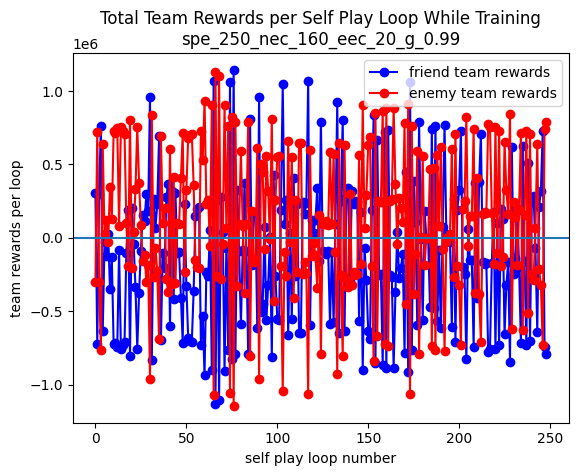

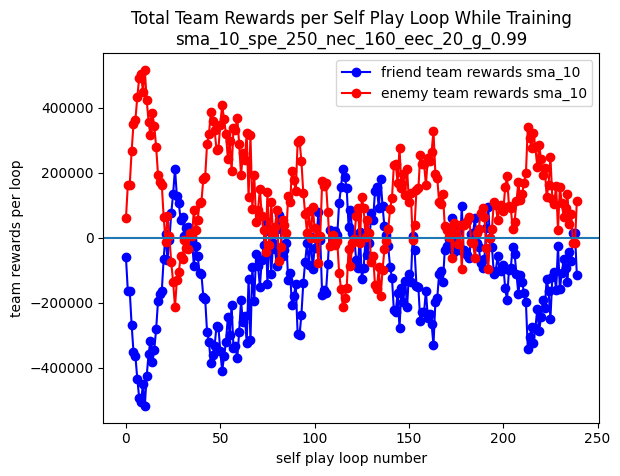

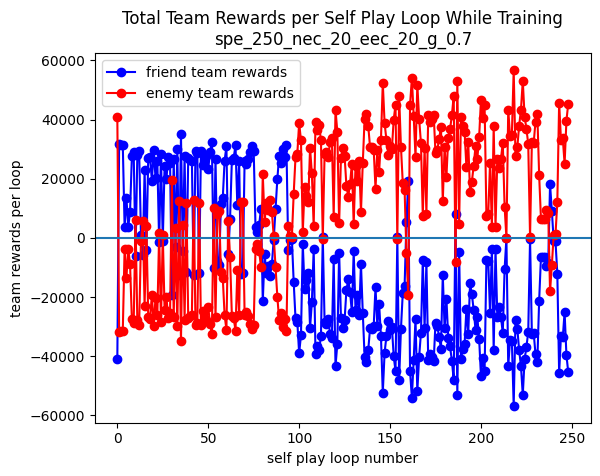

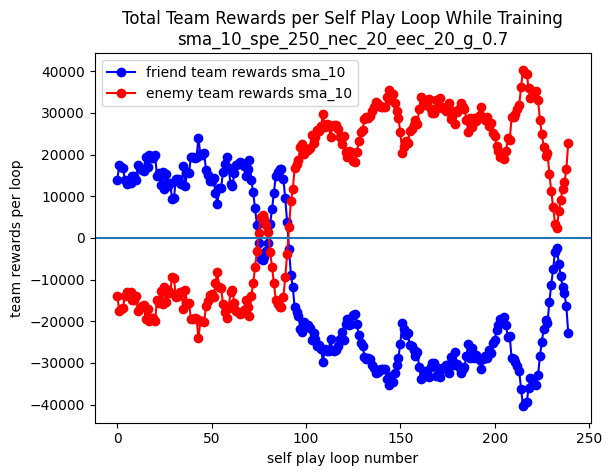

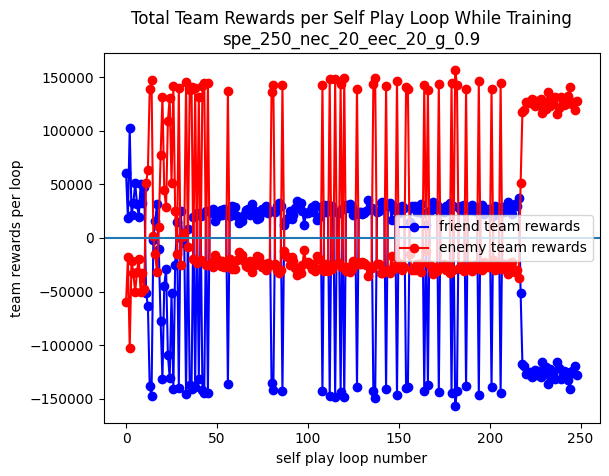

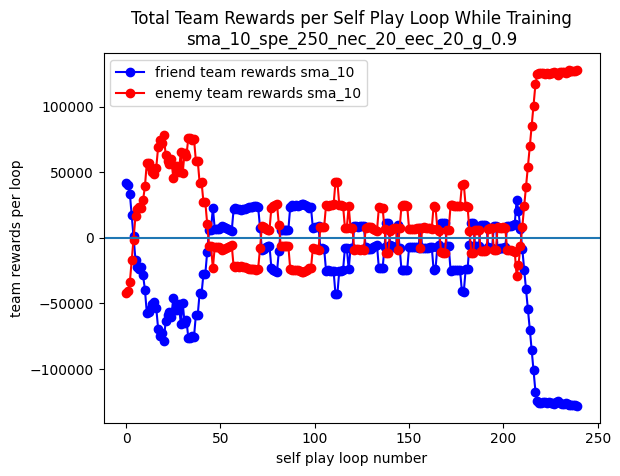

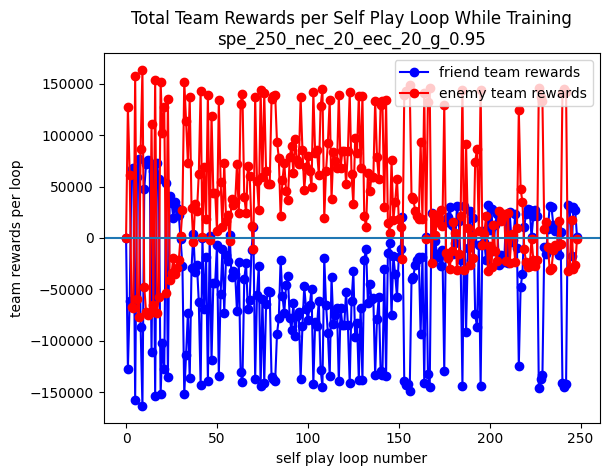

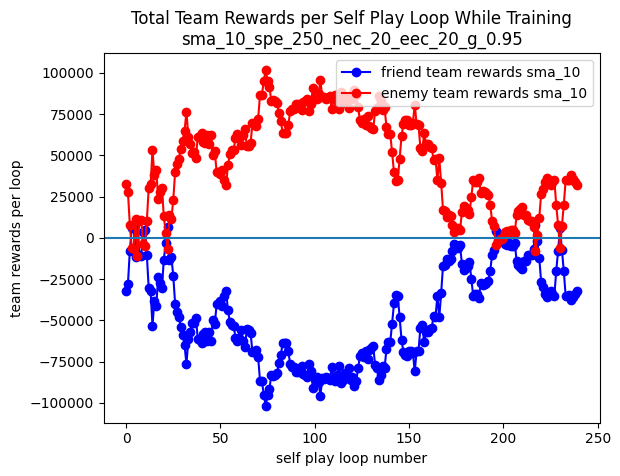

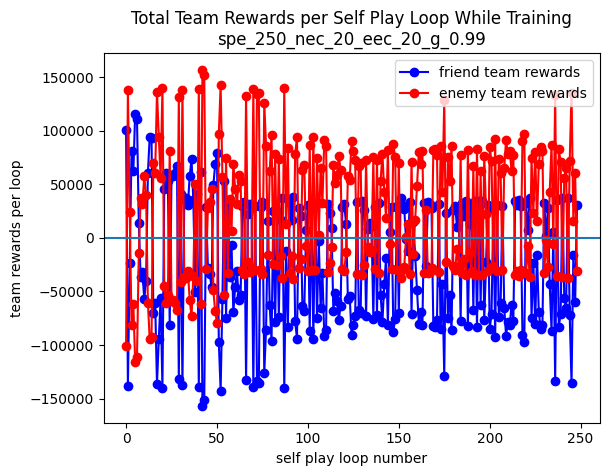

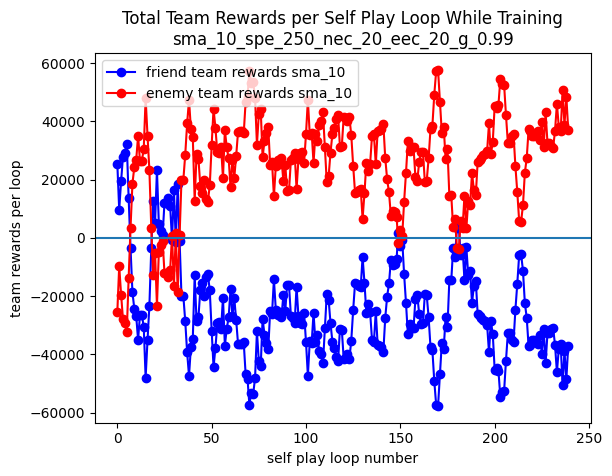

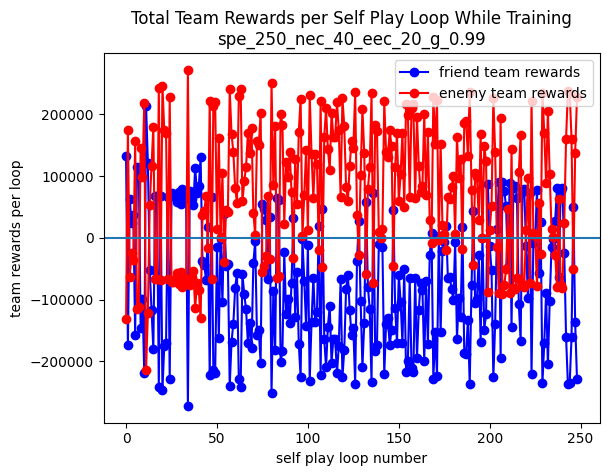

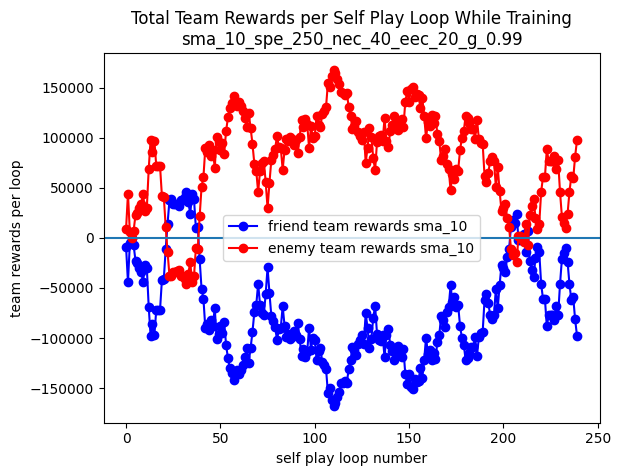

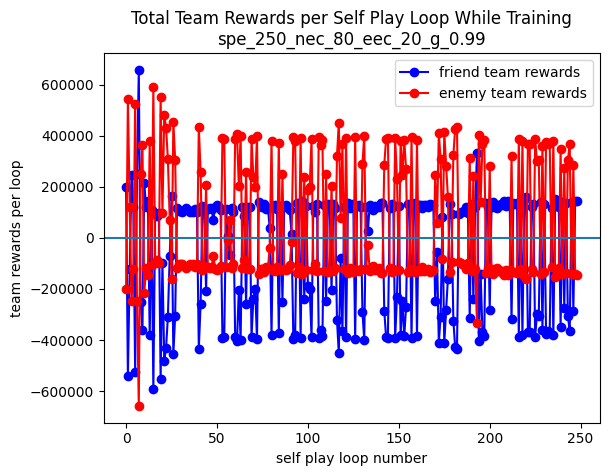

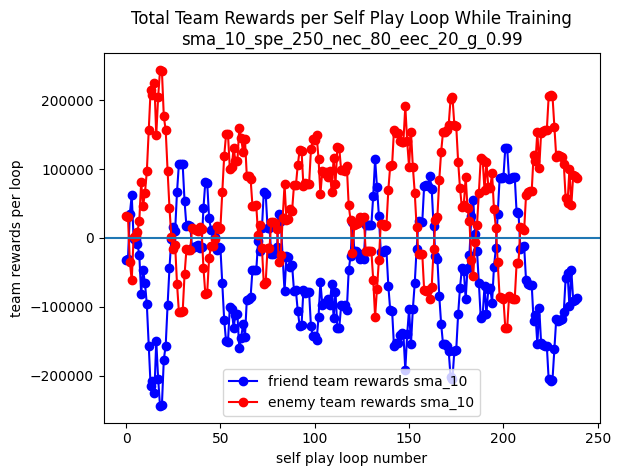

In [2]:
#This cell will search through all the trained model folders and graph the performance metrics
#in the form of total self play loop rewards for each team 

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sys
import os

BATCH_SIZE = 128
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

#[number of self play epochs, number of training episodes per self play epoch, number of eval episodes for each evaluation match, gamma]
#number of training episodes per self play epoch must be divisible by 2
#number of eval episodes for each evaluation match must be divisible by 2
hyperparameter_sets = [[250, 160, 20, .99], [250, 20, 20, .7], [250, 20, 20, .9], [250, 20, 20, .95], [250, 20, 20, .99], [250, 40, 20, .99], [250, 80, 20, .99]] 

for hyperset in hyperparameter_sets:
    self_play_epochs = hyperset[0]
    num_episodes_choice = hyperset[1]
    eval_episodes_choice = hyperset[2]
    GAMMA = hyperset[3]

    parent_directory = f"friend_state_dicts_spe_{self_play_epochs}_nec_{num_episodes_choice}_eec_{eval_episodes_choice}_g_{GAMMA}"
    child_directory = "performance"
    path = os.path.join(parent_directory, child_directory)
    if os.path.isdir(path):
        friend_rewards = np.load(f"{path}/self_play_rewards_friend.npy")
        enemy_rewards = np.load(f"{path}/self_play_rewards_enemy.npy")
        iterations = np.arange(friend_rewards.size)
        plt.plot(iterations, friend_rewards, "o-", label = "friend team rewards", color = "blue")
        plt.plot(iterations, enemy_rewards, "o-", label = "enemy team rewards", color = "red")
        plt.axhline(y = 0)
        plt.xlabel("self play loop number")
        plt.ylabel("team rewards per loop")
        plt.title(f"Total Team Rewards per Self Play Loop While Training\nspe_{self_play_epochs}"
                    f"_nec_{num_episodes_choice}_eec_{eval_episodes_choice}_g_{GAMMA}")
        plt.legend()
        plt.savefig(f"{path}/friend_ememy_spe_{self_play_epochs}_nec_{num_episodes_choice}_eec_{eval_episodes_choice}_g_{GAMMA}.png")
        plt.show()
        plt.close()

        window = 10
        sma_friend = np.convolve(friend_rewards, np.ones(window)/window, mode='valid')
        sma_enemy = np.convolve(enemy_rewards, np.ones(window)/window, mode='valid')
        iterations = np.arange(sma_friend.size)
        plt.plot(iterations, sma_friend, "o-", label = f"friend team rewards sma_{window}", color = "blue")
        plt.plot(iterations, sma_enemy, "o-", label = f"enemy team rewards sma_{window}", color = "red")
        plt.axhline(y = 0)
        plt.xlabel("self play loop number")
        plt.ylabel("team rewards per loop")
        plt.title(f"Total Team Rewards per Self Play Loop While Training\nsma_{window}_spe_{self_play_epochs}"
                    f"_nec_{num_episodes_choice}_eec_{eval_episodes_choice}_g_{GAMMA}")
        plt.legend()
        plt.savefig(f"{path}/friend_enemy_sma_10_spe_{self_play_epochs}_nec_{num_episodes_choice}_eec_{eval_episodes_choice}_g_{GAMMA}.png")
        plt.show()
        plt.close()
    
    else:
        print("WARNING:")
        print(f"{path} does not exist yet.\nPlease check hyperpatameter lists or training for a" 
                f"certain hyperparameter combination possibly has not completed")
        
        

In [3]:
#This will run through all the hyperparameter folders and obtain all relevant 
#self play information
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sys
import os

BATCH_SIZE = 128
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4


def bootstrap_ci(data, statistic=np.mean, n_bootstrap=1000, ci=95):
    boot_stats = np.array([
        statistic(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_bootstrap)])
    lower = (100 - ci) / 2
    upper = 100 - lower
    mid = np.mean(boot_stats)
    return mid, np.percentile(boot_stats, [lower, upper])

start_time = time.time()

repeat_epochs = 100

#[number of self play epochs, number of training episodes per self play epoch, number of eval episodes for each evaluation match, gamma]
#number of training episodes per self play epoch must be divisible by 2
#number of eval episodes for each evaluation match must be divisible by 2
hyperparameter_sets = [[250, 160, 20, .99], [250, 20, 20, .7], [250, 20, 20, .9], [250, 20, 20, .95], [250, 20, 20, .99], [250, 40, 20, .99], [250, 80, 20, .99]] 

for hyperset in hyperparameter_sets:
    
    self_play_epochs = hyperset[0]
    num_episodes_choice = hyperset[1]
    eval_episodes_choice = hyperset[2]
    GAMMA = hyperset[3]
                
    parent_directory = f"friend_state_dicts_spe_{self_play_epochs}_nec_{num_episodes_choice}_eec_{eval_episodes_choice}_g_{GAMMA}"
    print(f"Parent directory: {parent_directory}")
    
    if os.path.isdir(parent_directory):
        correct_num_agents = self_play_epochs * 6
        current_num_agents = len([x for x in os.listdir(parent_directory) if x.endswith(".pt")])
        if current_num_agents != correct_num_agents:
            print()
            print("WARNING:")
            print(f"{parent_directory} is not complete yet.\nPlease check for a" 
                  f"certain hyperparameter combination possibly has not completed")
            print()
            continue
            
        is_ipython = 'inline' in matplotlib.get_backend()
        if is_ipython:
            from IPython import display

        plt.ion()

        device = torch.device(
            "cuda" if torch.cuda.is_available() else
            "mps" if torch.backends.mps.is_available() else
            "cpu"
        )

        class DQN(nn.Module):
            """Deep Q-Network"""

            def __init__(self, n_observations, n_actions):
                super(DQN, self).__init__()
                self.layer1 = nn.Linear(n_observations, 128)
                self.layer2 = nn.Linear(128, 128)
                self.layer3 = nn.Linear(128, n_actions)

            def forward(self, x):
                x = F.relu(self.layer1(x))
                x = F.relu(self.layer2(x))
                return self.layer3(x)

        mean_list = []
        upper_ci_list = []
        lower_ci_list = []

        stalemate_list = []
        
        child_directory = "self_play_competition_data"
        output_path = os.path.join(parent_directory, child_directory)
        os.makedirs(output_path, exist_ok = True)

        for network_number in tqdm(range(self_play_epochs)):
            env_friend = CAGE4Environment(security_risk=0.1, success_rate=0.4, debug=False, team = "Friend")
            env_enemy = CAGE4Environment(security_risk=0.1, success_rate=0.4, debug=False, team = "Enemy")

            #must define red steps globally to be referenced in self play functions which are repeatedly defined
            red_steps_done_friend = 0
            red_steps_done_enemy = 0

            self_play_rewards_friend = []
            self_play_rewards_enemy = []


            for i in range(repeat_epochs):
                
                obs_friend, info_friend = env_friend.reset()
                agents_friend = list(obs_friend.keys())
                obs_enemy, info_enemy = env_enemy.reset()
                agents_enemy = list(obs_enemy.keys())
                    
                if i == 0:
                    #initialize friend agents on first loop
                    policy_nets_friend = {agent: DQN(len(obs_friend[agent]), len(env_friend.blue_agents[agent].action_mapping)).to(device) for agent in agents_friend}

                    red_policy_net_friend = DQN(len(env_enemy.true_state), len(env_enemy.red_agent.action_mapping)).to(device)

                    policy_nets_enemy = {agent: DQN(len(obs_enemy[agent]), len(env_enemy.blue_agents[agent].action_mapping)).to(device) for agent in agents_enemy}

                    red_policy_net_enemy = DQN(len(env_friend.true_state), len(env_friend.red_agent.action_mapping)).to(device)

                #copy current iteration of friend network into enemy network
                if list(policy_nets_friend.keys()) != list(policy_nets_enemy.keys()):
                    print("ERROR: Agent ordering in both friend and enemy policy nets must be the same!!!")
                    sys.exit()

                for agent in policy_nets_friend.keys():
                    path = f"{parent_directory}/{agent}_e_{network_number}.pt" 
                    state_dict_friend = torch.load(path)
                    policy_nets_friend[agent].load_state_dict(state_dict_friend)
                path = f"{parent_directory}/red_agent_e_{network_number}.pt" 
                red_state_dict_friend = torch.load(path)
                red_policy_net_friend.load_state_dict(red_state_dict_friend)

                for agent in policy_nets_enemy.keys():
                    path = f"{parent_directory}/{agent}_e_{network_number}.pt" 
                    state_dict_enemy = torch.load(path)
                    policy_nets_enemy[agent].load_state_dict(state_dict_enemy)    
                path = f"{parent_directory}/red_agent_e_{network_number}.pt" 
                red_state_dict_enemy = torch.load(path)
                red_policy_net_enemy.load_state_dict(red_state_dict_enemy)

                steps_done_friend = {agent: 0 for agent in agents_friend}
                red_steps_done_friend = 0
                steps_done_enemy = {agent: 0 for agent in agents_enemy}
                red_steps_done_enemy = 0

                # Define action selection function
                def select_action_friend(state, agent):
                    steps_done_friend[agent] += 1
                    with torch.no_grad():
                        return policy_nets_friend[agent](state).max(1).indices.view(1, 1)

                def select_action_enemy(state, agent):
                    steps_done_enemy[agent] += 1
                    with torch.no_grad():
                        return policy_nets_enemy[agent](state).max(1).indices.view(1, 1)

                def red_select_action_friend(state):
                    global red_steps_done_friend
                    red_steps_done_friend += 1
                    with torch.no_grad():
                        return red_policy_net_friend(state).max(1).indices.view(1, 1)

                def red_select_action_enemy(state):
                    global red_steps_done_enemy
                    red_steps_done_enemy += 1
                    with torch.no_grad():
                        return red_policy_net_enemy(state).max(1).indices.view(1, 1)

                # Training loop
                if torch.cuda.is_available() or torch.backends.mps.is_available():
                    num_episodes = 10
                    if num_episodes % 2 != 0:
                        print("ERROR!!! num_episodes must be even")
                        sys.exit()
                else:
                    num_episodes = 25

                reward_list_friend = {agent: [] for agent in agents_friend}
                reward_list_enemy = {agent: [] for agent in agents_enemy}
                red_reward_list_friend = []
                red_reward_list_enemy = []
                
                for i_episode in range(num_episodes):

                    obs_friend, info_friend = env_friend.reset()
                    obs_enemy, info_enemy = env_enemy.reset()

                    states_friend = {agent: torch.tensor(obs_friend[agent], dtype=torch.float32, device=device).unsqueeze(0) for agent in agents_friend}
                    states_enemy = {agent: torch.tensor(obs_enemy[agent], dtype=torch.float32, device=device).unsqueeze(0) for agent in agents_enemy}
                    red_state_friend = torch.tensor(list(env_enemy.true_state.values()), dtype = torch.float32, device = device).unsqueeze(0)
                    red_state_enemy = torch.tensor(list(env_friend.true_state.values()), dtype = torch.float32, device = device).unsqueeze(0)

                    temp_rewards_friend = {agent: 0 for agent in agents_friend}
                    temp_rewards_enemy = {agent: 0 for agent in agents_enemy}
                    red_temp_rewards_friend = 0
                    red_temp_rewards_enemy = 0
                    
                    MAX_T = 1000  # Maximum steps per episode
                    for t in range(MAX_T):
                        order_choice = random.random()
                        if order_choice < .5:
                            actions_friend = {agent: select_action_friend(states_friend[agent], agent).item() for agent in agents_friend}
                            red_action_enemy = red_select_action_enemy(red_state_enemy).item()
                            red_actions_enemy = {}
                            for agent in env_friend.red_agent.positions:
                                red_actions_enemy[agent.agent_id] = red_action_enemy
                            (
                                observation_friend, 
                                rewards_friend, 
                                terminated_friend, 
                                truncated_friend, 
                                _friend, 
                                red_observation_enemy, 
                                red_reward_enemy
                            ) = env_friend.step(actions_friend, red_actions_enemy)

                            actions_enemy = {agent: select_action_enemy(states_enemy[agent], agent).item() for agent in agents_enemy}
                            red_action_friend = red_select_action_friend(red_state_friend).item()
                            red_actions_friend = {}
                            for agent in env_enemy.red_agent.positions:
                                red_actions_friend[agent.agent_id] = red_action_friend
                            (
                                observation_enemy, 
                                rewards_enemy, 
                                terminated_enemy, 
                                truncated_enemy, 
                                _enemy, 
                                red_observation_friend, 
                                red_reward_friend 
                            ) = env_enemy.step(actions_enemy, red_actions_friend)   
                        else:
                            actions_enemy = {agent: select_action_enemy(states_enemy[agent], agent).item() for agent in agents_enemy}
                            red_action_friend = red_select_action_friend(red_state_friend).item()
                            red_actions_friend = {}
                            for agent in env_enemy.red_agent.positions:
                                red_actions_friend[agent.agent_id] = red_action_friend
                            (
                                observation_enemy, 
                                rewards_enemy, 
                                terminated_enemy, 
                                truncated_enemy, 
                                _enemy, 
                                red_observation_friend, 
                                red_reward_friend 
                            ) = env_enemy.step(actions_enemy, red_actions_friend)  
                
                            actions_friend = {agent: select_action_friend(states_friend[agent], agent).item() for agent in agents_friend}
                            red_action_enemy = red_select_action_enemy(red_state_enemy).item()
                            red_actions_enemy = {}
                            for agent in env_friend.red_agent.positions:
                                red_actions_enemy[agent.agent_id] = red_action_enemy
                            (
                                observation_friend, 
                                rewards_friend, 
                                terminated_friend, 
                                truncated_friend, 
                                _friend, 
                                red_observation_enemy, 
                                red_reward_enemy
                            ) = env_friend.step(actions_friend, red_actions_enemy)
                        
                        for agent in agents_friend:
                            temp_rewards_friend[agent] += rewards_friend[agent]
                            reward_friend = torch.tensor([rewards_friend[agent]], device=device)
                            done = terminated_friend[agent] or truncated_friend[agent]
                            if done:
                                next_state_friend = None
                            else:
                                next_state_friend = torch.tensor(observation_friend[agent], dtype=torch.float32, device=device).unsqueeze(0)
                            states_friend[agent] = next_state_friend

                        for agent in agents_enemy:
                            temp_rewards_enemy[agent] += rewards_enemy[agent]
                            reward_enemy = torch.tensor([rewards_enemy[agent]], device=device)
                            done = terminated_enemy[agent] or truncated_enemy[agent]
                            if done:
                                next_state_enemy = None
                            else:
                                next_state_enemy = torch.tensor(observation_enemy[agent], dtype=torch.float32, device=device).unsqueeze(0)
                            states_friend[agent] = next_state_enemy  

                        red_temp_rewards_friend += red_reward_friend
                        if np.sum(np.array(list(temp_rewards_enemy.values()))) != (-1 * red_temp_rewards_friend):
                            print("ERROR!!!")
                            print(np.sum(np.array(list(temp_rewards_friend.values()))))
                            print(red_temp_rewards_enemy)
                        red_reward_friend = torch.tensor([red_reward_friend], device=device)
                        red_next_state_friend = torch.tensor(list(red_observation_friend.values()), dtype=torch.float32, device = device).unsqueeze(0)
                        red_state_friend = red_next_state_friend

                        red_temp_rewards_enemy += red_reward_enemy
                        if np.sum(np.array(list(temp_rewards_friend.values()))) != (-1 * red_temp_rewards_enemy):
                            print("ERROR!!!")
                            print(np.sum(np.array(list(temp_rewards_friend.values()))))
                            print(red_temp_rewards_enemy)
                        red_reward_enemy = torch.tensor([red_reward_enemy], device=device)
                        red_next_state_enemy = torch.tensor(list(red_observation_enemy.values()), dtype=torch.float32, device = device).unsqueeze(0)
                        red_state_enemy = red_next_state_enemy

                        second_order_choice = random.random()
                        if second_order_choice < .5:
                            if all(terminated_friend[agent] or truncated_friend[agent] for agent in agents_friend):
                                break
                            if all(terminated_enemy[agent] or truncated_enemy[agent] for agent in agents_enemy):
                                break
                        else:
                            if all(terminated_enemy[agent] or truncated_enemy[agent] for agent in agents_enemy):
                                break
                            if all(terminated_friend[agent] or truncated_friend[agent] for agent in agents_friend):
                                break
                    
                    for agent in agents_friend:
                        reward_list_friend[agent].append(temp_rewards_friend[agent])
                    for agent in agents_enemy:
                        reward_list_enemy[agent].append(temp_rewards_enemy[agent])
                    red_reward_list_friend.append(red_temp_rewards_friend)
                    red_reward_list_enemy.append(red_temp_rewards_enemy)

                blue_total_rewards_friend = np.zeros(num_episodes)
                for agent in agents_friend:
                    blue_total_rewards_friend += np.array(reward_list_friend[agent])
                red_total_rewards_friend = np.array(red_reward_list_friend)
                total_rewards_friend = (blue_total_rewards_friend + red_total_rewards_friend).tolist()
                self_play_rewards_friend.extend(total_rewards_friend)
                
                blue_total_rewards_enemy = np.zeros(num_episodes)
                for agent in agents_enemy:
                    blue_total_rewards_enemy += np.array(reward_list_enemy[agent])
                red_total_rewards_enemy = np.array(red_reward_list_enemy)
                total_rewards_enemy = (blue_total_rewards_enemy + red_total_rewards_enemy).tolist()
                self_play_rewards_enemy.extend(total_rewards_enemy)

            mean, bounds = bootstrap_ci(np.array(self_play_rewards_friend))
            mean_list.append(mean)
            upper_ci_list.append(bounds[1])
            lower_ci_list.append(bounds[0])
            
            if (bounds[0] <= 0) and (bounds[1] >= 0):
                ci_contains_zero = 1
            else: 
                ci_contains_zero = 0
            stalemate_list.append(ci_contains_zero)

            np.save(f"{output_path}/self_play_rewards_friend_{network_number}.npy", np.array(self_play_rewards_friend))

        np.save(f"{output_path}/mean_list.npy", np.array(mean_list))
        np.save(f"{output_path}/upper_ci_list.npy", np.array(upper_ci_list))
        np.save(f"{output_path}/lower_ci_list.npy", np.array(lower_ci_list))
        np.save(f"{output_path}/stalemate_list.npy", np.array(stalemate_list))                    

    else:
        print()
        print("WARNING:")
        print(f"{parent_directory} does not exist.\nPlease check hyperpatameter lists")
        print()

end_time = time.time()
print('Complete')
print(f'Time elapsed is {(end_time - start_time)/60:.2f} minutes')


Parent directory: friend_state_dicts_spe_250_nec_160_eec_20_g_0.99


  0%|          | 0/250 [00:07<?, ?it/s]


KeyboardInterrupt: 

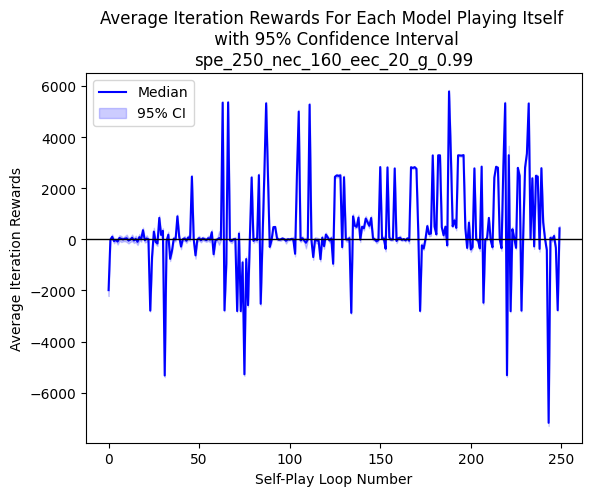

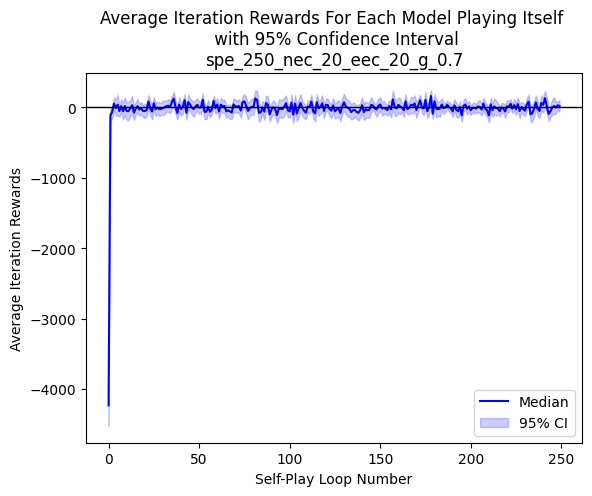

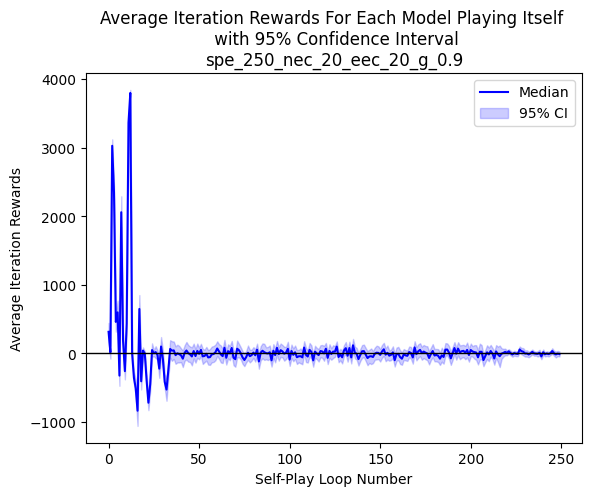

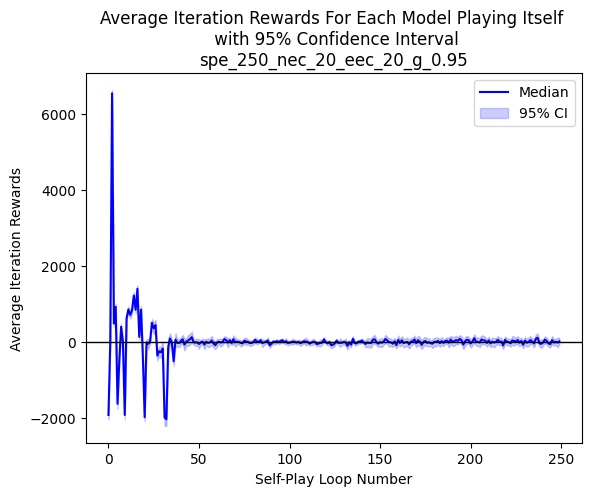

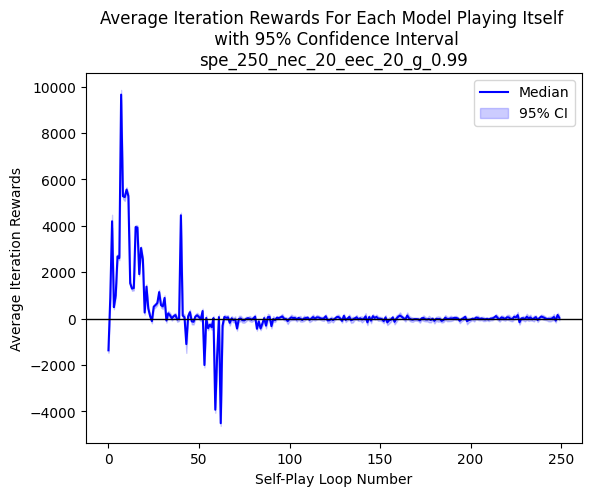

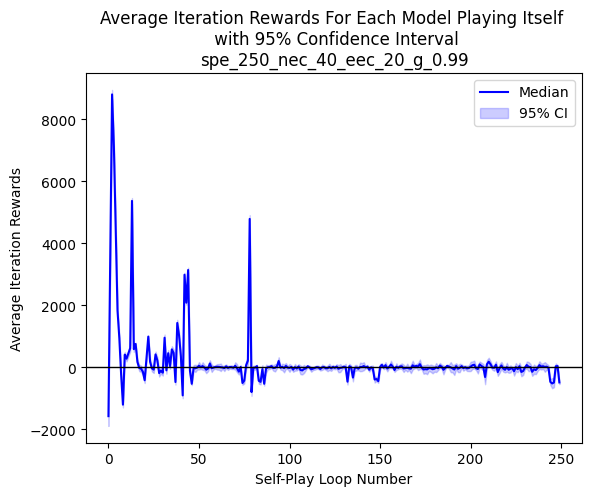

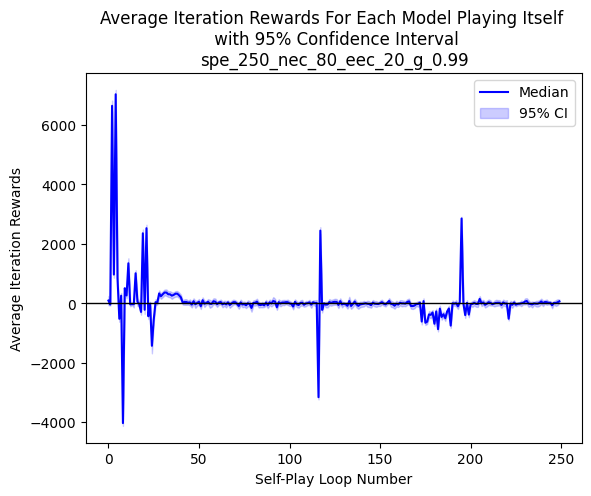

In [3]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sys
import os

BATCH_SIZE = 128
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

hyperparameter_sets = [[250, 160, 20, .99], [250, 20, 20, .7], [250, 20, 20, .9], [250, 20, 20, .95], [250, 20, 20, .99], [250, 40, 20, .99], [250, 80, 20, .99]] 

for hyperset in hyperparameter_sets:
    
    self_play_epochs = hyperset[0]
    num_episodes_choice = hyperset[1]
    eval_episodes_choice = hyperset[2]
    GAMMA = hyperset[3]
    
    parent_directory = f"friend_state_dicts_spe_{self_play_epochs}_nec_{num_episodes_choice}_eec_{eval_episodes_choice}_g_{GAMMA}"
    child_directory = "self_play_competition_data"
    path = os.path.join(parent_directory, child_directory)
    if os.path.isdir(path):
        if not os.path.exists(f"{path}/mean_list.npy"):
            print()
            print("WARNING:")
            print(f"{path} is not complete yet.\nPlease check for a" 
                  f"certain hyperparameter combination possibly has not completed")
            print()
            continue

        mean_list = np.load(f"{path}/mean_list.npy")
        lower_ci_list = np.load(f"{path}/lower_ci_list.npy")
        upper_ci_list = np.load(f"{path}/upper_ci_list.npy")
        x = np.arange(mean_list.size)  # or whatever x-axis values you have
        # Assume you already have these arrays: lower_ci, median, upper_ci
        
        plt.plot(x, mean_list, label='Median', color='blue')
        plt.fill_between(x, lower_ci_list, upper_ci_list, color='blue', alpha=0.2, label='95% CI')
        plt.axhline(0, color='black', linewidth=1)
        plt.xlabel('Self-Play Loop Number')  # customize as needed
        plt.ylabel('Average Iteration Rewards')
        plt.title(f'Average Iteration Rewards For Each Model Playing Itself \n with 95% Confidence Interval\nspe_{self_play_epochs}'
                    f'_nec_{num_episodes_choice}_eec_{eval_episodes_choice}_g_{GAMMA}')
        plt.legend()
        #plt.savefig(f"figures/median_with_ci")
        plt.show()
        plt.close()
        
    else:
        print()
        print("WARNING:")
        print(f"{path} does not exist.\nPlease check hyperpatameter lists")
        print()
        

In [ ]:
#Run through all stalemate models for a given hyperparameter set and return the best model
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sys
import os

BATCH_SIZE = 128
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

num_eval_episodes = 4

start_time = time.time()

hyperparameter_sets = [[250, 160, 20, .99], [250, 20, 20, .7], [250, 20, 20, .9], [250, 20, 20, .95], [250, 20, 20, .99], [250, 40, 20, .99], [250, 80, 20, .99]] 

for hyperset in hyperparameter_sets:
    
    self_play_epochs = hyperset[0]
    num_episodes_choice = hyperset[1]
    eval_episodes_choice = hyperset[2]
    GAMMA = hyperset[3]

    parent_directory = f"friend_state_dicts_spe_{self_play_epochs}_nec_{num_episodes_choice}_eec_{eval_episodes_choice}_g_{GAMMA}"
    print(f"Parent directory: {parent_directory}")
    child_directory = "self_play_competition_data"
    path = os.path.join(parent_directory, child_directory)
    if os.path.isdir(path):    
        if not os.path.exists(f"{path}/stalemate_list.npy"):
            print()
            print("WARNING:")
            print(f"{path} is not complete yet.\nPlease check for a" 
                  f"certain hyperparameter combination possibly has not completed")
            continue
        
        os.makedirs(f"{path}/best_model", exist_ok = True)
        
        is_ipython = 'inline' in matplotlib.get_backend()
        if is_ipython:
            from IPython import display

        plt.ion()

        device = torch.device(
            "cuda" if torch.cuda.is_available() else
            "mps" if torch.backends.mps.is_available() else
            "cpu"
        )

        class DQN(nn.Module):
            """Deep Q-Network"""

            def __init__(self, n_observations, n_actions):
                super(DQN, self).__init__()
                self.layer1 = nn.Linear(n_observations, 128)
                self.layer2 = nn.Linear(128, 128)
                self.layer3 = nn.Linear(128, n_actions)

            def forward(self, x):
                x = F.relu(self.layer1(x))
                x = F.relu(self.layer2(x))
                return self.layer3(x)

        stalemate_list = np.load(f"{path}/stalemate_list.npy")

        #which models are stalemate models 
        model_list = np.where(stalemate_list == 1)[0]

        total_wins_team = np.zeros(model_list.size)
        total_rewards_team = np.zeros(model_list.size)
        total_count_team = np.zeros(model_list.size)

        
        #loop through all each model and then all future models down the line
        #every model plays every model and we see how who gets the most wins 
        for j in tqdm(range(model_list.size - 1)):
            for k in tqdm((range(j+1, model_list.size))):
                
                env_friend = CAGE4Environment(security_risk=0.1, success_rate=0.4, debug=False, team = "Friend")
                env_enemy = CAGE4Environment(security_risk=0.1, success_rate=0.4, debug=False, team = "Enemy")

                #must define red steps globally to be referenced in self play functions which are repeatedly defined
                red_steps_done_friend = 0
                red_steps_done_enemy = 0

                wins_team_1 = 0
                wins_team_2 = 0
                rewards_team_1 = []
                rewards_team_2 = []
                
                team_1_model_number = model_list[j].item()
                team_2_model_number = model_list[k].item()

                for i in range(2):
                        
                    obs_friend, info_friend = env_friend.reset()
                    agents_friend = list(obs_friend.keys())
                    obs_enemy, info_enemy = env_enemy.reset()
                    agents_enemy = list(obs_enemy.keys())

                    if i == 0:
                        #initialize friend agents on first loop
                        policy_nets_friend = {agent: DQN(len(obs_friend[agent]), len(env_friend.blue_agents[agent].action_mapping)).to(device) for agent in agents_friend}

                        red_policy_net_friend = DQN(len(env_enemy.true_state), len(env_enemy.red_agent.action_mapping)).to(device)

                        policy_nets_enemy = {agent: DQN(len(obs_enemy[agent]), len(env_enemy.blue_agents[agent].action_mapping)).to(device) for agent in agents_enemy}

                        red_policy_net_enemy = DQN(len(env_friend.true_state), len(env_friend.red_agent.action_mapping)).to(device)

                    #copy current iteration of friend network into enemy network
                    if list(policy_nets_friend.keys()) != list(policy_nets_enemy.keys()):
                        print("ERROR: Agent ordering in both friend and enemy policy nets must be the same!!!")
                        sys.exit()
                    if i == 0:
                        for agent in policy_nets_friend.keys():
                            input_path = f"{parent_directory}/{agent}_e_{team_1_model_number}.pt" 
                            state_dict_friend = torch.load(input_path)
                            policy_nets_friend[agent].load_state_dict(state_dict_friend)
                        input_path = f"{parent_directory}/red_agent_e_{team_1_model_number}.pt" 
                        red_state_dict_friend = torch.load(input_path)
                        red_policy_net_friend.load_state_dict(red_state_dict_friend)

                        for agent in policy_nets_enemy.keys():
                            input_path = f"{parent_directory}/{agent}_e_{team_2_model_number}.pt" 
                            state_dict_enemy = torch.load(input_path)
                            policy_nets_enemy[agent].load_state_dict(state_dict_enemy)    
                        input_path = f"{parent_directory}/red_agent_e_{team_2_model_number}.pt" 
                        red_state_dict_enemy = torch.load(input_path)
                        red_policy_net_enemy.load_state_dict(red_state_dict_enemy)
                    else:
                        for agent in policy_nets_friend.keys():
                            input_path = f"{parent_directory}/{agent}_e_{team_2_model_number}.pt" 
                            state_dict_friend = torch.load(input_path)
                            policy_nets_friend[agent].load_state_dict(state_dict_friend)
                        input_path = f"{parent_directory}/red_agent_e_{team_2_model_number}.pt" 
                        red_state_dict_friend = torch.load(input_path)
                        red_policy_net_friend.load_state_dict(red_state_dict_friend)

                        for agent in policy_nets_enemy.keys():
                            input_path = f"{parent_directory}/{agent}_e_{team_1_model_number}.pt" 
                            state_dict_enemy = torch.load(input_path)
                            policy_nets_enemy[agent].load_state_dict(state_dict_enemy)    
                        input_path = f"{parent_directory}/red_agent_e_{team_1_model_number}.pt" 
                        red_state_dict_enemy = torch.load(input_path)
                        red_policy_net_enemy.load_state_dict(red_state_dict_enemy)

                    steps_done_friend = {agent: 0 for agent in agents_friend}
                    red_steps_done_friend = 0
                    steps_done_enemy = {agent: 0 for agent in agents_enemy}
                    red_steps_done_enemy = 0

                    # Define action selection function
                    def select_action_friend(state, agent):
                        steps_done_friend[agent] += 1
                        with torch.no_grad():
                            return policy_nets_friend[agent](state).max(1).indices.view(1, 1)

                    def select_action_enemy(state, agent):
                        steps_done_enemy[agent] += 1
                        with torch.no_grad():
                            return policy_nets_enemy[agent](state).max(1).indices.view(1, 1)

                    def red_select_action_friend(state):
                        global red_steps_done_friend
                        red_steps_done_friend += 1
                        with torch.no_grad():
                            return red_policy_net_friend(state).max(1).indices.view(1, 1)

                    def red_select_action_enemy(state):
                        global red_steps_done_enemy
                        red_steps_done_enemy += 1
                        with torch.no_grad():
                            return red_policy_net_enemy(state).max(1).indices.view(1, 1)

                    # Training loop
                    if torch.cuda.is_available() or torch.backends.mps.is_available():
                        num_episodes = num_eval_episodes
                        if num_episodes % 2 != 0:
                            print("ERROR!!! num_episodes must be even")
                            sys.exit()
                    else:
                        num_episodes = 26

                    reward_list_friend = {agent: [] for agent in agents_friend}
                    reward_list_enemy = {agent: [] for agent in agents_enemy}
                    red_reward_list_friend = []
                    red_reward_list_enemy = []
                    
                    for i_episode in range(num_episodes):

                        obs_friend, info_friend = env_friend.reset()
                        obs_enemy, info_enemy = env_enemy.reset()

                        states_friend = {agent: torch.tensor(obs_friend[agent], dtype=torch.float32, device=device).unsqueeze(0) for agent in agents_friend}
                        states_enemy = {agent: torch.tensor(obs_enemy[agent], dtype=torch.float32, device=device).unsqueeze(0) for agent in agents_enemy}
                        red_state_friend = torch.tensor(list(env_enemy.true_state.values()), dtype = torch.float32, device = device).unsqueeze(0)
                        red_state_enemy = torch.tensor(list(env_friend.true_state.values()), dtype = torch.float32, device = device).unsqueeze(0)

                        temp_rewards_friend = {agent: 0 for agent in agents_friend}
                        temp_rewards_enemy = {agent: 0 for agent in agents_enemy}
                        red_temp_rewards_friend = 0
                        red_temp_rewards_enemy = 0
                        
                        MAX_T = 1000  # Maximum steps per episode
                        for t in range(MAX_T):
                            order_choice = random.random()
                            if order_choice < .5:
                                actions_friend = {agent: select_action_friend(states_friend[agent], agent).item() for agent in agents_friend}
                                red_action_enemy = red_select_action_enemy(red_state_enemy).item()
                                red_actions_enemy = {}
                                for agent in env_friend.red_agent.positions:
                                    red_actions_enemy[agent.agent_id] = red_action_enemy
                                (
                                    observation_friend, 
                                    rewards_friend, 
                                    terminated_friend, 
                                    truncated_friend, 
                                    _friend, 
                                    red_observation_enemy, 
                                    red_reward_enemy
                                ) = env_friend.step(actions_friend, red_actions_enemy)

                                actions_enemy = {agent: select_action_enemy(states_enemy[agent], agent).item() for agent in agents_enemy}
                                red_action_friend = red_select_action_friend(red_state_friend).item()
                                red_actions_friend = {}
                                for agent in env_enemy.red_agent.positions:
                                    red_actions_friend[agent.agent_id] = red_action_friend
                                (
                                    observation_enemy, 
                                    rewards_enemy, 
                                    terminated_enemy, 
                                    truncated_enemy, 
                                    _enemy, 
                                    red_observation_friend, 
                                    red_reward_friend 
                                ) = env_enemy.step(actions_enemy, red_actions_friend)   
                            else:
                                actions_enemy = {agent: select_action_enemy(states_enemy[agent], agent).item() for agent in agents_enemy}
                                red_action_friend = red_select_action_friend(red_state_friend).item()
                                red_actions_friend = {}
                                for agent in env_enemy.red_agent.positions:
                                    red_actions_friend[agent.agent_id] = red_action_friend
                                (
                                    observation_enemy, 
                                    rewards_enemy, 
                                    terminated_enemy, 
                                    truncated_enemy, 
                                    _enemy, 
                                    red_observation_friend, 
                                    red_reward_friend 
                                ) = env_enemy.step(actions_enemy, red_actions_friend)  
                    
                                actions_friend = {agent: select_action_friend(states_friend[agent], agent).item() for agent in agents_friend}
                                red_action_enemy = red_select_action_enemy(red_state_enemy).item()
                                red_actions_enemy = {}
                                for agent in env_friend.red_agent.positions:
                                    red_actions_enemy[agent.agent_id] = red_action_enemy
                                (
                                    observation_friend, 
                                    rewards_friend, 
                                    terminated_friend, 
                                    truncated_friend, 
                                    _friend, 
                                    red_observation_enemy, 
                                    red_reward_enemy
                                ) = env_friend.step(actions_friend, red_actions_enemy)
                            
                            for agent in agents_friend:
                                temp_rewards_friend[agent] += rewards_friend[agent]
                                reward_friend = torch.tensor([rewards_friend[agent]], device=device)
                                done = terminated_friend[agent] or truncated_friend[agent]
                                if done:
                                    next_state_friend = None
                                else:
                                    next_state_friend = torch.tensor(observation_friend[agent], dtype=torch.float32, device=device).unsqueeze(0)
                                states_friend[agent] = next_state_friend

                            for agent in agents_enemy:
                                temp_rewards_enemy[agent] += rewards_enemy[agent]
                                reward_enemy = torch.tensor([rewards_enemy[agent]], device=device)
                                done = terminated_enemy[agent] or truncated_enemy[agent]
                                if done:
                                    next_state_enemy = None
                                else:
                                    next_state_enemy = torch.tensor(observation_enemy[agent], dtype=torch.float32, device=device).unsqueeze(0)
                                states_friend[agent] = next_state_enemy  

                            red_temp_rewards_friend += red_reward_friend
                            if np.sum(np.array(list(temp_rewards_enemy.values()))) != (-1 * red_temp_rewards_friend):
                                print("ERROR!!!")
                                print(np.sum(np.array(list(temp_rewards_friend.values()))))
                                print(red_temp_rewards_enemy)
                            red_reward_friend = torch.tensor([red_reward_friend], device=device)
                            red_next_state_friend = torch.tensor(list(red_observation_friend.values()), dtype=torch.float32, device = device).unsqueeze(0)
                            red_state_friend = red_next_state_friend

                            red_temp_rewards_enemy += red_reward_enemy
                            if np.sum(np.array(list(temp_rewards_friend.values()))) != (-1 * red_temp_rewards_enemy):
                                print("ERROR!!!")
                                print(np.sum(np.array(list(temp_rewards_friend.values()))))
                                print(red_temp_rewards_enemy)
                            red_reward_enemy = torch.tensor([red_reward_enemy], device=device)
                            red_next_state_enemy = torch.tensor(list(red_observation_enemy.values()), dtype=torch.float32, device = device).unsqueeze(0)
                            red_state_enemy = red_next_state_enemy

                            second_order_choice = random.random()
                            if second_order_choice < .5:
                                if all(terminated_friend[agent] or truncated_friend[agent] for agent in agents_friend):
                                    break
                                if all(terminated_enemy[agent] or truncated_enemy[agent] for agent in agents_enemy):
                                    break
                            else:
                                if all(terminated_enemy[agent] or truncated_enemy[agent] for agent in agents_enemy):
                                    break
                                if all(terminated_friend[agent] or truncated_friend[agent] for agent in agents_friend):
                                    break
                        
                        for agent in agents_friend:
                            reward_list_friend[agent].append(temp_rewards_friend[agent])
                        for agent in agents_enemy:
                            reward_list_enemy[agent].append(temp_rewards_enemy[agent])
                        red_reward_list_friend.append(red_temp_rewards_friend)
                        red_reward_list_enemy.append(red_temp_rewards_enemy)

                    blue_total_rewards_friend = np.zeros(num_episodes)
                    for agent in agents_friend:
                        blue_total_rewards_friend += np.array(reward_list_friend[agent])
                    red_total_rewards_friend = np.array(red_reward_list_friend)
                    total_rewards_friend = blue_total_rewards_friend + red_total_rewards_friend
                    
                    
                    blue_total_rewards_enemy = np.zeros(num_episodes)
                    for agent in agents_enemy:
                        blue_total_rewards_enemy += np.array(reward_list_enemy[agent])
                    red_total_rewards_enemy = np.array(red_reward_list_enemy)
                    total_rewards_enemy = blue_total_rewards_enemy + red_total_rewards_enemy
                    
                    if i == 0:
                        wins_team_1 += np.sum(total_rewards_friend > 0)
                        wins_team_2 += np.sum(total_rewards_enemy > 0)
                        rewards_team_1.extend(total_rewards_friend.tolist())
                        rewards_team_2.extend(total_rewards_enemy.tolist())
                    else:
                        wins_team_1 += np.sum(total_rewards_enemy > 0)
                        wins_team_2 += np.sum(total_rewards_friend > 0)
                        rewards_team_1.extend(total_rewards_enemy.tolist())
                        rewards_team_2.extend(total_rewards_friend.tolist())
                        
                if wins_team_1 > wins_team_2:
                    total_wins_team[j] += 1
                elif wins_team_1 < wins_team_2:
                    total_wins_team[k] += 1
                
                total_rewards_team[j] += np.mean(np.array(rewards_team_1))
                total_count_team[j] += 1
                total_rewards_team[k] += np.mean(np.array(rewards_team_2))
                total_count_team[k] += 1

            checkpoint_path = f"{path}/best_model/checkpoint_{j}_of_{model_list.size}.txt"
            with open(checkpoint_path, "w") as f:
                pass            
        
        total_rewards_team = total_rewards_team / total_count_team
        
        np.save(f"{path}/best_model/total_wins_team.npy", total_wins_team)
        np.save(f"{path}/best_model/total_rewards_team.npy", total_rewards_team)
        np.save(f"{path}/best_model/model_list.npy", model_list)

        max_wins = np.max(total_wins_team)
        if np.sum(total_wins_team == max_wins) > 1:
            max_reward_index = np.where(total_wins_team == max_wins)[0]
            x = np.argmax(total_rewards_team[max_reward_index])
            max_reward_index = max_reward_index[x]
            best_model_number = model_list[max_reward_index].item()
        else:
            best_model_number = model_list[np.argmax(total_wins_team)].item()

        for agent in policy_nets_friend.keys():
            input_path = f"{parent_directory}/{agent}_e_{best_model_number}.pt" 
            best_state_dict = torch.load(input_path)
            output_path = f"{path}/best_model/{agent}_e_{best_model_number}.pt"
            torch.save(best_state_dict, output_path)
        input_path = f"{parent_directory}/red_agent_e_{best_model_number}.pt" 
        red_best_state_dict = torch.load(input_path)
        output_path = f"{path}/best_model/red_agent_e_{best_model_number}.pt"
        torch.save(red_best_state_dict, output_path)

    else:
        print()
        print("WARNING:")
        print(f"{path} does not exist.\nPlease check hyperpatameter lists")                    
        print()
        
end_time = time.time()
print('Complete')
print(f'Time elapsed is {(end_time - start_time)/60:.2f} minutes')

Parent directory: friend_state_dicts_spe_250_nec_160_eec_20_g_0.99


 66%|██████▋   | 69/104 [02:28<01:15,  2.15s/it]

In [30]:
#loop through all hyperparameters combos, find the best model, match them against one another and produce a global best
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sys
import os

BATCH_SIZE = 128
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

num_eval_episodes = 10

hyperparameter_sets = [[250, 160, 20, .99], [250, 20, 20, .7], [250, 20, 20, .9], [250, 20, 20, .95], [250, 20, 20, .99], [250, 40, 20, .99], [250, 80, 20, .99]] 

best_teams = []
#organize groups of paths for all best teams
for hyperset in hyperparameter_sets:
    
    self_play_epochs = hyperset[0]
    num_episodes_choice = hyperset[1]
    eval_episodes_choice = hyperset[2]
    GAMMA = hyperset[3]
    current_team = []
    path = (
        f"friend_state_dicts_spe_{self_play_epochs}_nec_{num_episodes_choice}_eec_{eval_episodes_choice}_g_{GAMMA}"
        f"/self_play_competition_data/best_model"
    )
                                 
    if os.path.isdir(path):
        best_model_files = os.listdir(path)
        model_files = [f for f in best_model_files if f.endswith(".pt")]
        for file in model_files:
            total_path = os.path.join(path, file)
            current_team.append(total_path)
        if current_team:
            best_teams.append(current_team)
    else:
        print("WARNING:")
        print(f"{path} does not exist.\nPlease check hyperpatameter lists") 


if len(best_teams) < 2:
    print()
    print("ERROR: Need at least two teams.  Two teams are not complete.")
    print(best_teams)
    sys.exit()

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

class DQN(nn.Module):
    """Deep Q-Network"""

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

total_wins_team = np.zeros(len(best_teams))
total_rewards_team = np.zeros(len(best_teams))
total_count_team = np.zeros(len(best_teams))

#loop through all each model and then all future models down the line
#every model plays every model and we see how who gets the most wins
for i, team in enumerate(best_teams):
    print()
    print(f"team{i}: {team}")
    print()

for j in tqdm(range(len(best_teams) - 1)):
    for k in tqdm((range(j+1, len(best_teams)))):
        
        env_friend = CAGE4Environment(security_risk=0.1, success_rate=0.4, debug=False, team = "Friend")
        env_enemy = CAGE4Environment(security_risk=0.1, success_rate=0.4, debug=False, team = "Enemy")

        #must define red steps globally to be referenced in self play functions which are repeatedly defined
        red_steps_done_friend = 0
        red_steps_done_enemy = 0

        wins_team_1 = 0
        wins_team_2 = 0
        rewards_team_1 = []
        rewards_team_2 = []

        team_1 = best_teams[j]
        team_2 = best_teams[k]

        for i in range(2):
                
            obs_friend, info_friend = env_friend.reset()
            agents_friend = list(obs_friend.keys())
            obs_enemy, info_enemy = env_enemy.reset()
            agents_enemy = list(obs_enemy.keys())

            if i == 0:
                #initialize friend agents on first loop
                policy_nets_friend = {agent: DQN(len(obs_friend[agent]), len(env_friend.blue_agents[agent].action_mapping)).to(device) for agent in agents_friend}

                red_policy_net_friend = DQN(len(env_enemy.true_state), len(env_enemy.red_agent.action_mapping)).to(device)

                policy_nets_enemy = {agent: DQN(len(obs_enemy[agent]), len(env_enemy.blue_agents[agent].action_mapping)).to(device) for agent in agents_enemy}

                red_policy_net_enemy = DQN(len(env_friend.true_state), len(env_friend.red_agent.action_mapping)).to(device)

            #copy current iteration of friend network into enemy network
            if list(policy_nets_friend.keys()) != list(policy_nets_enemy.keys()):
                print("ERROR: Agent ordering in both friend and enemy policy nets must be the same!!!")
                sys.exit()
            if i == 0:
                friend_blue_team_count = 0
                friend_red_team_count = 0
                for agent in policy_nets_friend.keys():
                    for path in team_1:
                        head, tail = os.path.split(path)
                        test = tail.split("_")[0]
                        if test == agent:
                            state_dict_friend = torch.load(path, map_location = device)
                            policy_nets_friend[agent].load_state_dict(state_dict_friend)
                            friend_blue_team_count += 1
                for path in team_1:
                    head, tail = os.path.split(path)
                    test = tail.split("_")[0]
                    if test == "red":
                        red_state_dict_friend = torch.load(path, map_location = device)
                        red_policy_net_friend.load_state_dict(red_state_dict_friend)
                        friend_red_team_count += 1
                if (friend_blue_team_count != 5) and (friend_red_team_count != 1):
                    print("ERROR: incorrect team!!!")
                    sys.exit()

                enemy_blue_team_count = 0
                enemy_red_team_count = 0
                for agent in policy_nets_enemy.keys():
                    for path in team_2:
                        head, tail = os.path.split(path)
                        test = tail.split("_")[0]
                        if test == agent:
                            state_dict_enemy = torch.load(path, map_location = device)
                            policy_nets_enemy[agent].load_state_dict(state_dict_enemy)
                            enemy_blue_team_count += 1
                for path in team_2:
                    head, tail = os.path.split(path)
                    test = tail.split("_")[0]
                    if test == "red":
                        red_state_dict_enemy = torch.load(path, map_location = device)
                        red_policy_net_enemy.load_state_dict(red_state_dict_enemy)
                        enemy_red_team_count += 1
                if (enemy_blue_team_count != 5) and (enemy_red_team_count != 1):
                    print("ERROR: incorrect team!!!")
                    sys.exit()
            else:
                friend_blue_team_count = 0
                friend_red_team_count = 0
                for agent in policy_nets_friend.keys():
                    for path in team_2:
                        head, tail = os.path.split(path)
                        test = tail.split("_")[0]
                        if test == agent:
                            state_dict_friend = torch.load(path, map_location = device)
                            policy_nets_friend[agent].load_state_dict(state_dict_friend)
                            friend_blue_team_count += 1
                for path in team_2:
                    head, tail = os.path.split(path)
                    test = tail.split("_")[0]
                    if test == "red":
                        red_state_dict_friend = torch.load(path, map_location = device)
                        red_policy_net_friend.load_state_dict(red_state_dict_friend)
                        friend_red_team_count += 1
                if (friend_blue_team_count != 5) and (friend_red_team_count != 1):
                    print("ERROR: incorrect team!!!")
                    sys.exit()

                enemy_blue_team_count = 0
                enemy_red_team_count = 0
                for agent in policy_nets_enemy.keys():
                    for path in team_1:
                        head, tail = os.path.split(path)
                        test = tail.split("_")[0]
                        if test == agent:
                            state_dict_enemy = torch.load(path, map_location = device)
                            policy_nets_enemy[agent].load_state_dict(state_dict_enemy)
                            enemy_blue_team_count += 1
                for path in team_1:
                    head, tail = os.path.split(path)
                    test = tail.split("_")[0]
                    if test == "red":
                        red_state_dict_enemy = torch.load(path, map_location = device)
                        red_policy_net_enemy.load_state_dict(red_state_dict_enemy)
                        enemy_red_team_count += 1
                if (enemy_blue_team_count != 5) and (enemy_red_team_count != 1):
                    print("ERROR: incorrect team!!!")
                    sys.exit()

            steps_done_friend = {agent: 0 for agent in agents_friend}
            red_steps_done_friend = 0
            steps_done_enemy = {agent: 0 for agent in agents_enemy}
            red_steps_done_enemy = 0

            # Define action selection function
            def select_action_friend(state, agent):
                steps_done_friend[agent] += 1
                with torch.no_grad():
                    return policy_nets_friend[agent](state).max(1).indices.view(1, 1)

            def select_action_enemy(state, agent):
                steps_done_enemy[agent] += 1
                with torch.no_grad():
                    return policy_nets_enemy[agent](state).max(1).indices.view(1, 1)

            def red_select_action_friend(state):
                global red_steps_done_friend
                red_steps_done_friend += 1
                with torch.no_grad():
                    return red_policy_net_friend(state).max(1).indices.view(1, 1)

            def red_select_action_enemy(state):
                global red_steps_done_enemy
                red_steps_done_enemy += 1
                with torch.no_grad():
                    return red_policy_net_enemy(state).max(1).indices.view(1, 1)

            # Training loop
            if torch.cuda.is_available() or torch.backends.mps.is_available():
                num_episodes = num_eval_episodes
                if num_episodes % 2 != 0:
                    print("ERROR!!! num_episodes must be even")
                    sys.exit()
            else:
                num_episodes = 26

            reward_list_friend = {agent: [] for agent in agents_friend}
            reward_list_enemy = {agent: [] for agent in agents_enemy}
            red_reward_list_friend = []
            red_reward_list_enemy = []
            
            for i_episode in range(num_episodes):

                obs_friend, info_friend = env_friend.reset()
                obs_enemy, info_enemy = env_enemy.reset()

                states_friend = {agent: torch.tensor(obs_friend[agent], dtype=torch.float32, device=device).unsqueeze(0) for agent in agents_friend}
                states_enemy = {agent: torch.tensor(obs_enemy[agent], dtype=torch.float32, device=device).unsqueeze(0) for agent in agents_enemy}
                red_state_friend = torch.tensor(list(env_enemy.true_state.values()), dtype = torch.float32, device = device).unsqueeze(0)
                red_state_enemy = torch.tensor(list(env_friend.true_state.values()), dtype = torch.float32, device = device).unsqueeze(0)

                temp_rewards_friend = {agent: 0 for agent in agents_friend}
                temp_rewards_enemy = {agent: 0 for agent in agents_enemy}
                red_temp_rewards_friend = 0
                red_temp_rewards_enemy = 0
                
                MAX_T = 1000  # Maximum steps per episode
                for t in range(MAX_T):
                    order_choice = random.random()
                    if order_choice < .5:
                        actions_friend = {agent: select_action_friend(states_friend[agent], agent).item() for agent in agents_friend}
                        red_action_enemy = red_select_action_enemy(red_state_enemy).item()
                        red_actions_enemy = {}
                        for agent in env_friend.red_agent.positions:
                            red_actions_enemy[agent.agent_id] = red_action_enemy
                        (
                            observation_friend, 
                            rewards_friend, 
                            terminated_friend, 
                            truncated_friend, 
                            _friend, 
                            red_observation_enemy, 
                            red_reward_enemy
                        ) = env_friend.step(actions_friend, red_actions_enemy)

                        actions_enemy = {agent: select_action_enemy(states_enemy[agent], agent).item() for agent in agents_enemy}
                        red_action_friend = red_select_action_friend(red_state_friend).item()
                        red_actions_friend = {}
                        for agent in env_enemy.red_agent.positions:
                            red_actions_friend[agent.agent_id] = red_action_friend
                        (
                            observation_enemy, 
                            rewards_enemy, 
                            terminated_enemy, 
                            truncated_enemy, 
                            _enemy, 
                            red_observation_friend, 
                            red_reward_friend 
                        ) = env_enemy.step(actions_enemy, red_actions_friend)   
                    else:
                        actions_enemy = {agent: select_action_enemy(states_enemy[agent], agent).item() for agent in agents_enemy}
                        red_action_friend = red_select_action_friend(red_state_friend).item()
                        red_actions_friend = {}
                        for agent in env_enemy.red_agent.positions:
                            red_actions_friend[agent.agent_id] = red_action_friend
                        (
                            observation_enemy, 
                            rewards_enemy, 
                            terminated_enemy, 
                            truncated_enemy, 
                            _enemy, 
                            red_observation_friend, 
                            red_reward_friend 
                        ) = env_enemy.step(actions_enemy, red_actions_friend)  
            
                        actions_friend = {agent: select_action_friend(states_friend[agent], agent).item() for agent in agents_friend}
                        red_action_enemy = red_select_action_enemy(red_state_enemy).item()
                        red_actions_enemy = {}
                        for agent in env_friend.red_agent.positions:
                            red_actions_enemy[agent.agent_id] = red_action_enemy
                        (
                            observation_friend, 
                            rewards_friend, 
                            terminated_friend, 
                            truncated_friend, 
                            _friend, 
                            red_observation_enemy, 
                            red_reward_enemy
                        ) = env_friend.step(actions_friend, red_actions_enemy)
                    
                    for agent in agents_friend:
                        temp_rewards_friend[agent] += rewards_friend[agent]
                        reward_friend = torch.tensor([rewards_friend[agent]], device=device)
                        done = terminated_friend[agent] or truncated_friend[agent]
                        if done:
                            next_state_friend = None
                        else:
                            next_state_friend = torch.tensor(observation_friend[agent], dtype=torch.float32, device=device).unsqueeze(0)
                        states_friend[agent] = next_state_friend

                    for agent in agents_enemy:
                        temp_rewards_enemy[agent] += rewards_enemy[agent]
                        reward_enemy = torch.tensor([rewards_enemy[agent]], device=device)
                        done = terminated_enemy[agent] or truncated_enemy[agent]
                        if done:
                            next_state_enemy = None
                        else:
                            next_state_enemy = torch.tensor(observation_enemy[agent], dtype=torch.float32, device=device).unsqueeze(0)
                        states_friend[agent] = next_state_enemy  

                    red_temp_rewards_friend += red_reward_friend
                    if np.sum(np.array(list(temp_rewards_enemy.values()))) != (-1 * red_temp_rewards_friend):
                        print("ERROR!!!")
                        print(np.sum(np.array(list(temp_rewards_friend.values()))))
                        print(red_temp_rewards_enemy)
                    red_reward_friend = torch.tensor([red_reward_friend], device=device)
                    red_next_state_friend = torch.tensor(list(red_observation_friend.values()), dtype=torch.float32, device = device).unsqueeze(0)
                    red_state_friend = red_next_state_friend

                    red_temp_rewards_enemy += red_reward_enemy
                    if np.sum(np.array(list(temp_rewards_friend.values()))) != (-1 * red_temp_rewards_enemy):
                        print("ERROR!!!")
                        print(np.sum(np.array(list(temp_rewards_friend.values()))))
                        print(red_temp_rewards_enemy)
                    red_reward_enemy = torch.tensor([red_reward_enemy], device=device)
                    red_next_state_enemy = torch.tensor(list(red_observation_enemy.values()), dtype=torch.float32, device = device).unsqueeze(0)
                    red_state_enemy = red_next_state_enemy

                    second_order_choice = random.random()
                    if second_order_choice < .5:
                        if all(terminated_friend[agent] or truncated_friend[agent] for agent in agents_friend):
                            break
                        if all(terminated_enemy[agent] or truncated_enemy[agent] for agent in agents_enemy):
                            break
                    else:
                        if all(terminated_enemy[agent] or truncated_enemy[agent] for agent in agents_enemy):
                            break
                        if all(terminated_friend[agent] or truncated_friend[agent] for agent in agents_friend):
                            break
                
                for agent in agents_friend:
                    reward_list_friend[agent].append(temp_rewards_friend[agent])
                for agent in agents_enemy:
                    reward_list_enemy[agent].append(temp_rewards_enemy[agent])
                red_reward_list_friend.append(red_temp_rewards_friend)
                red_reward_list_enemy.append(red_temp_rewards_enemy)

            blue_total_rewards_friend = np.zeros(num_episodes)
            for agent in agents_friend:
                blue_total_rewards_friend += np.array(reward_list_friend[agent])
            red_total_rewards_friend = np.array(red_reward_list_friend)
            total_rewards_friend = blue_total_rewards_friend + red_total_rewards_friend
            
            
            blue_total_rewards_enemy = np.zeros(num_episodes)
            for agent in agents_enemy:
                blue_total_rewards_enemy += np.array(reward_list_enemy[agent])
            red_total_rewards_enemy = np.array(red_reward_list_enemy)
            total_rewards_enemy = blue_total_rewards_enemy + red_total_rewards_enemy
            
            if i == 0:
                wins_team_1 += np.sum(total_rewards_friend > 0)
                wins_team_2 += np.sum(total_rewards_enemy > 0 )
                rewards_team_1.extend(total_rewards_friend.tolist())
                rewards_team_2.extend(total_rewards_enemy.tolist())
            else:
                wins_team_1 += np.sum(total_rewards_enemy > 0)
                wins_team_2 += np.sum(total_rewards_friend > 0)
                rewards_team_1.extend(total_rewards_enemy.tolist())
                rewards_team_2.extend(total_rewards_friend.tolist())

        
        if wins_team_1 > wins_team_2:
            total_wins_team[j] += 1
        elif wins_team_1 < wins_team_2:
            total_wins_team[k] += 1
        
        total_rewards_team[j] += np.mean(np.array(rewards_team_1))
        total_count_team[j] += 1
        total_rewards_team[k] += np.mean(np.array(rewards_team_2))
        total_count_team[k] += 1


total_rewards_team = total_rewards_team / total_count_team
    

os.makedirs(f"best_global_model", exist_ok = True)
np.save(f"best_global_model/total_wins_team.npy", total_wins_team)
np.save(f"best_global_model/total_rewards_team.npy", total_rewards_team)

max_wins = np.max(total_wins_team)
if np.sum(total_wins_team == max_wins) > 1:
    max_reward_index = np.where(total_wins_team == max_wins)[0]
    x = np.argmax(total_rewards_team[max_reward_index])
    max_reward_index = max_reward_index[x]
    best_model_number = max_reward_index
else:
    best_model_number = np.argmax(total_wins_team).item()

best_model = best_teams[best_model_number]
print()
print(f"best_model: {best_model}")
print()
print(f"best_model_index: {best_model_number}")
file_path = "best_global_model/best_model_paths.txt"
with open(file_path, 'w') as f:
    for line in best_model:
        f.write(line + '\n')                 
                
print('Complete')

friend_state_dicts_spe_250_nec_160_eec_20_g_0.99/self_play_competition_data/best_model does not exist.
Please check hyperpatameter lists
friend_state_dicts_spe_250_nec_20_eec_20_g_0.7/self_play_competition_data/best_model does not exist.
Please check hyperpatameter lists
friend_state_dicts_spe_250_nec_20_eec_20_g_0.9/self_play_competition_data/best_model does not exist.
Please check hyperpatameter lists
friend_state_dicts_spe_250_nec_20_eec_20_g_0.95/self_play_competition_data/best_model does not exist.
Please check hyperpatameter lists
friend_state_dicts_spe_250_nec_20_eec_20_g_0.99/self_play_competition_data/best_model does not exist.
Please check hyperpatameter lists
friend_state_dicts_spe_250_nec_40_eec_20_g_0.99/self_play_competition_data/best_model does not exist.
Please check hyperpatameter lists
friend_state_dicts_spe_250_nec_80_eec_20_g_0.99/self_play_competition_data/best_model does not exist.
Please check hyperpatameter lists

ERROR: Need at least two teams.  Two teams are n

SystemExit: 

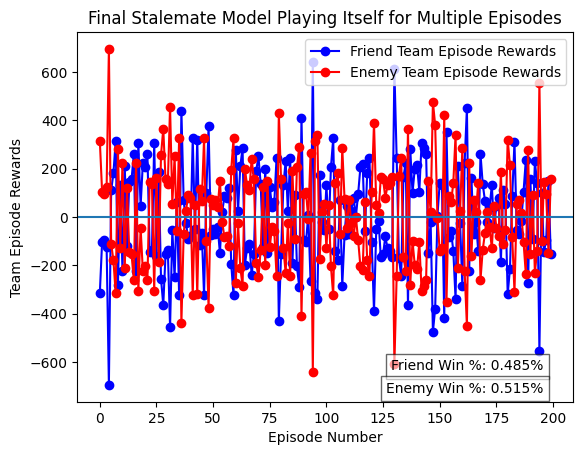

In [43]:
y_friend = np.load("friend_state_dicts_spe_250_nec_20_eec_20_g_0.9/self_play_competition_data/self_play_rewards_friend_244.npy")
friend_win_pct = np.sum(y_friend > 0) / y_friend.size
y_enemy = -1 * y_friend
enemy_win_pct = 1 - friend_win_pct
x  = np.arange(x.size)
plt.plot(x, y_friend, "-o", color = "blue", label = "Friend Team Episode Rewards")
plt.plot(x, y_enemy, "-o", color = "red", label = "Enemy Team Episode Rewards")
plt.axhline(y = 0)
plt.ylabel("Team Episode Rewards")
plt.xlabel("Episode Number")
plt.title("Final Stalemate Model Playing Itself for Multiple Episodes")
x_pos = 0.94
y_start = 0.115
line_spacing = 0.06

# Add friend win percentage
plt.text(x_pos, y_start, f'Friend Win %: {friend_win_pct:}%',
         transform=plt.gca().transAxes, verticalalignment='top',
         horizontalalignment='right', fontsize=10,
         bbox=dict(facecolor='white', alpha=0.6))

# Add enemy win percentage, spaced consistently below the friend
plt.text(x_pos, y_start - line_spacing, f'Enemy Win %: {enemy_win_pct}%',
         transform=plt.gca().transAxes, verticalalignment='top',
         horizontalalignment='right', fontsize=10,
         bbox=dict(facecolor='white', alpha=0.6))
plt.legend(loc = 'upper right')
plt.show()
plt.close()

In [48]:
print("Stalemate Test: Avg Team Rewards Per Episode")
print(f"Friend Team Avg Episode Rewards: {np.mean(y_friend)}")
print(f"Enemy Team Avg Episode Rewards: {np.mean(y_enemy)}")

Stalemate Test: Avg Team Rewards Per Episode
Friend Team Avg Episode Rewards: -0.075
Enemy Team Avg Episode Rewards: 0.075
